In [2]:
# Configurações Iniciais de saída
options (scipen = 999, 
         digits = 4,
        repos = 'http://cran.rstudio.com/',
        repr.plot.width = 20,
        repr.plot.height = 10)

In [ ]:
if(!require(pacman))
install.packages('pacman')
library('pacman')
pacman::p_load(dplyr, caret, ROSE, randomForest, data.table, pROC, ROCR, gridExtra)

In [10]:
# Carregando o conjunto de dados
df <- readRDS('/kaggle/input/dataset-formated/df1_v1.RDS')

In [11]:
# Verificando as primeiras observações
df1 <- df
head(df1)

,tempo,tipo_transacao,valor_transacao,saldo_anterior_origem,novo_saldo_origem,saldo_anterior_destino,novo_saldo_destino,isfraude,erro_saldo_origem,erro_saldo_destino
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,1,Transferencia,181,181,0,0,0,1,0,181
2,1,Saque,181,181,0,21182,0,1,0,21363
3,1,Saque,229134,15325,0,5083,51513,0,213809,182704
4,1,Transferencia,215310,705,0,22425,0,0,214605,237735
5,1,Transferencia,311686,10835,0,6267,2719173,0,300851,-2401220
6,1,Saque,110415,26845,0,288800,2415,0,83569,396800


In [12]:
# Verificando os tipos dos dados
str(df1)

'data.frame':	2770409 obs. of  10 variables:
 $ tempo                 : num  1 1 1 1 1 1 1 1 1 1 ...
 $ tipo_transacao        : Factor w/ 2 levels "Saque","Transferencia": 2 1 1 2 2 1 1 1 1 2 ...
 $ valor_transacao       : num  181 181 229134 215310 311686 ...
 $ saldo_anterior_origem : num  181 181 15325 705 10835 ...
 $ novo_saldo_origem     : num  0 0 0 0 0 ...
 $ saldo_anterior_destino: num  0 21182 5083 22425 6267 ...
 $ novo_saldo_destino    : num  0 0 51513 0 2719173 ...
 $ isfraude              : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 1 1 1 ...
 $ erro_saldo_origem     : num  0 0 213809 214605 300851 ...
 $ erro_saldo_destino    : num  181 21363 182704 237735 -2401220 ...


In [13]:
# Criando a variável dummies para tipo de transacao
tipo_transacao_dummies <- model.matrix(~ tipo_transacao - 1, df1)
df1 <- cbind(df1,tipo_transacao_dummies)
df1 <- select(df1, -isfraude, -tipo_transacao, isfraude)

# Alterando os dados para categóricos
df1$tipo_transacaoSaque <- as.factor(df1$tipo_transacaoSaque)
df1$tipo_transacaoTransferencia <- as.factor(df1$tipo_transacaoTransferencia)
head(df1)

,tempo,valor_transacao,saldo_anterior_origem,novo_saldo_origem,saldo_anterior_destino,novo_saldo_destino,erro_saldo_origem,erro_saldo_destino,tipo_transacaoSaque,tipo_transacaoTransferencia,isfraude
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,1,181,181,0,0,0,0,181,0,1,1
2,1,181,181,0,21182,0,0,21363,1,0,1
3,1,229134,15325,0,5083,51513,213809,182704,1,0,0
4,1,215310,705,0,22425,0,214605,237735,0,1,0
5,1,311686,10835,0,6267,2719173,300851,-2401220,0,1,0
6,1,110415,26845,0,288800,2415,83569,396800,1,0,0


In [14]:
# Verificando os tipos dos dados
str(df1)

'data.frame':	2770409 obs. of  11 variables:
 $ tempo                      : num  1 1 1 1 1 1 1 1 1 1 ...
 $ valor_transacao            : num  181 181 229134 215310 311686 ...
 $ saldo_anterior_origem      : num  181 181 15325 705 10835 ...
 $ novo_saldo_origem          : num  0 0 0 0 0 ...
 $ saldo_anterior_destino     : num  0 21182 5083 22425 6267 ...
 $ novo_saldo_destino         : num  0 0 51513 0 2719173 ...
 $ erro_saldo_origem          : num  0 0 213809 214605 300851 ...
 $ erro_saldo_destino         : num  181 21363 182704 237735 -2401220 ...
 $ tipo_transacaoSaque        : Factor w/ 2 levels "0","1": 1 2 2 1 1 2 2 2 2 1 ...
 $ tipo_transacaoTransferencia: Factor w/ 2 levels "0","1": 2 1 1 2 2 1 1 1 1 2 ...
 $ isfraude                   : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 1 1 1 ...


# 7. Divisão do Conjunto de dados

Nesta etapa, o conjunto de dados é dividido em treino, teste e validação.
* Treino (70% do conjunto original);
* Validação (30% do conjunto de treino);
* Teste (30% do conjunto original)

In [15]:
# Dividindo os dados em treino, validação e teste
set.seed(123)

# Separando 70% para base de treino e 30% para teste
indices <- caret::createDataPartition(df1$isfraude, p = 0.70, list = FALSE)

treino <- df1[indices,]
teste <- df1[-indices,]

# A partir da base de treino, separando 20% para validação
indices2 <- caret::createDataPartition(treino$isfraude, p = 0.70, list = FALSE)

treino <- treino[indices2,]
validacao <- treino[-indices2,]

# Visualizando as dimensões dos datasets
sprintf('A base de treino possui %s observações e %s variáveis',
        dim(treino)[1], dim(treino)[2])

sprintf('A base de validação possui %s observações e %s variáveis',
        dim(validacao)[1], dim(validacao)[2])

sprintf('A base de teste possui %s observações e %s variáveis',
        dim(teste)[1], dim(teste)[2])

[1] "A base de treino possui 1357502 observações e 11 variáveis"

[1] "A base de validação possui 407617 observações e 11 variáveis"

[1] "A base de teste possui 831121 observações e 11 variáveis"

# SAVEPOINT

In [8]:
# Importando as bases finais separadas
treino <- readRDS('/kaggle/input/bases-desbalanceadas/treino.RDS')
validacao <- readRDS('/kaggle/input/bases-desbalanceadas/valid.RDS')
teste <- readRDS('/kaggle/input/bases-desbalanceadas/teste.RDS')

Como os dados não seguem uma distribuição normal, será realizado a normalização para escala [0 e 1] devido o uso de alguns algoritmos sensíveis a outliers, como SVM e Redes Neurais

# 8. Balanceamento com SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de balanceamento de dados que cria novas amostras sintéticas para a classe minoritária, aumentando sua representação. Ela gera exemplos intermediários ao interpolar pontos próximos da classe minoritária, ajudando a evitar o overfitting e a melhorar a performance em classificações desequilibradas.

In [10]:
# Realizando o balanceamento SMOTE
treino <- ROSE::ovun.sample(isfraude ~., data = treino,
                                        method = 'both', p = 0.5, seed = 123)$data
table(treino$isfraude)


     0      1 
679392 678110 

# 9. Normalização dos dados

A normalização dos dados é o processo de ajustar a escala das variáveis para que elas fiquem dentro de um intervalo específico, como [0, 1], sem alterar suas relações. Isso facilita a comparação entre variáveis de diferentes unidades e melhora o desempenho de algoritmos de aprendizado de máquina que são sensíveis à escala, como redes neurais e SVMs.

In [12]:
# Identificar colunas numéricas
colunas_numericas <- sapply(treino, is.numeric)

# Calcular os valores mínimos e máximos dos dados de treino apenas para as colunas numéricas
treino_min <- apply(treino[, colunas_numericas], 2, min)
treino_max <- apply(treino[, colunas_numericas], 2, max)

# Função de normalização
normalize <- function(x, min, max) {
  (x - min) / (max - min)
}

# Normalizar os dados de treino
treino_normalizado <- as.data.frame(treino)
treino_normalizado[, colunas_numericas] <- mapply(normalize, treino[, colunas_numericas], treino_min, treino_max, SIMPLIFY = FALSE)

# Normalizar os dados de validação e teste usando os mesmos valores mínimos e máximos dos dados de treino
validacao_normalizada <- as.data.frame(validacao)
validacao_normalizada[, colunas_numericas] <- mapply(normalize, validacao[, colunas_numericas], treino_min, treino_max, SIMPLIFY = FALSE)

teste_normalizado <- as.data.frame(teste)
teste_normalizado[, colunas_numericas] <- mapply(normalize, teste[, colunas_numericas], treino_min, treino_max, SIMPLIFY = FALSE)

In [13]:
summary(treino_normalizado)

     tempo       valor_transacao  saldo_anterior_origem novo_saldo_origem
 Min.   :0.000   Min.   :0.0000   Min.   :0.0000        Min.   :0.0000   
 1st Qu.:0.214   1st Qu.:0.0017   1st Qu.:0.0000        1st Qu.:0.0000   
 Median :0.379   Median :0.0040   Median :0.0013        Median :0.0000   
 Mean   :0.408   Mean   :0.0155   Mean   :0.0167        Mean   :0.0026   
 3rd Qu.:0.543   3rd Qu.:0.0110   3rd Qu.:0.0089        3rd Qu.:0.0000   
 Max.   :1.000   Max.   :1.0000   Max.   :1.0000        Max.   :1.0000   
 saldo_anterior_destino novo_saldo_destino erro_saldo_origem erro_saldo_destino
 Min.   :0.0000         Min.   :0.0000     Min.   :0.0000    Min.   :0.000     
 1st Qu.:0.0000         1st Qu.:0.0000     1st Qu.:0.0000    1st Qu.:0.879     
 Median :0.0004         Median :0.0015     Median :0.0000    Median :0.879     
 Mean   :0.0035         Mean   :0.0051     Mean   :0.0026    Mean   :0.883     
 3rd Qu.:0.0028         3rd Qu.:0.0051     3rd Qu.:0.0026    3rd Qu.:0.880     
 M

In [15]:
# Salvando os conjuntos de dados normalizados
saveRDS(treino_normalizado, file = 'treino_normalizado.RDS')
saveRDS(validacao_normalizada, file = 'validacao_normalizada.RDS')
saveRDS(teste_normalizado, file = 'teste_normalizado.RDS')

# SAVE POINT 


In [5]:
# Importando as bases normalizadas
treino_normalizado <- readRDS('/kaggle/input/bases-normalizadas/treino_normalizado.RDS')
validacao_normalizada <- readRDS('/kaggle/input/bases-normalizadas/validacao_normalizada.RDS')
teste_normalizado <- readRDS('/kaggle/input/bases-normalizadas/teste_normalizado.RDS')

In [6]:
# Criando uma subamostragem
set.seed(123)
indice <- caret::createDataPartition(treino_normalizado$isfraude, p=0.04, list=FALSE)
treino_amostra <- treino_normalizado[indice,]

# Verificando os fatores da variável resposta
levels(treino_amostra$isfraude) <- make.names(levels(treino_amostra$isfraude))

# Níveis ajustados
levels(treino_amostra$isfraude)

summary(treino_amostra)

[1] "X0" "X1"

     tempo       valor_transacao  saldo_anterior_origem novo_saldo_origem
 Min.   :0.000   Min.   :0.0000   Min.   :0.0000        Min.   :0.0000   
 1st Qu.:0.216   1st Qu.:0.0017   1st Qu.:0.0000        1st Qu.:0.0000   
 Median :0.379   Median :0.0041   Median :0.0013        Median :0.0000   
 Mean   :0.409   Mean   :0.0156   Mean   :0.0168        Mean   :0.0026   
 3rd Qu.:0.543   3rd Qu.:0.0112   3rd Qu.:0.0090        3rd Qu.:0.0000   
 Max.   :1.000   Max.   :0.6356   Max.   :1.0000        Max.   :0.9751   
 saldo_anterior_destino novo_saldo_destino erro_saldo_origem erro_saldo_destino
 Min.   :0.0000         Min.   :0.0000     Min.   :0.0000    Min.   :0.474     
 1st Qu.:0.0000         1st Qu.:0.0000     1st Qu.:0.0000    1st Qu.:0.879     
 Median :0.0004         Median :0.0015     Median :0.0000    Median :0.879     
 Mean   :0.0035         Mean   :0.0052     Mean   :0.0027    Mean   :0.883     
 3rd Qu.:0.0028         3rd Qu.:0.0051     3rd Qu.:0.0026    3rd Qu.:0.880     
 M

****
# 10. Treinamento dos Modelos Supervisionados
## 10.1. Random Forest
### 10.1.1 Random Forest (Versão 1)
O Random Forest é um algoritmo de aprendizado de máquina baseado em árvores de decisão. Ele funciona criando diversas árvores independentes (uma "floresta") a partir de amostras aleatórias dos dados. Cada árvore toma decisões baseadas em partes dos dados e, ao final, as previsões das árvores são combinadas para formar uma decisão final. O algoritmo é robusto contra overfitting e tem alta acurácia, sendo amplamente utilizado para tarefas de classificação e regressão. A diversidade das árvores ajuda a melhorar a generalização do modelo.

In [ ]:
# Definindo o grid de hiperparâmetros
grid <- expand.grid(mtry = 6)

# Treinando o modelo com busca em grade
fitControl <- trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary)


# Calcula o tempo de processamento do modelo
rf_time_v1 <- system.time({
 
  rf_model_v1 <- train(
    isfraude ~ ., 
    data = treino_amostra, 
    method = "rf", 
    trControl = fitControl, 
    tuneGrid = grid, 
    metric = "ROC", 
    ntree = 300, 
    nodesize = c(10, 20, 30))
    
})

# Visualizando os resultados
print(rf_time_v1)
print('--------------------------------------------------------------------------------------------------------')
print(rf_model_v1)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v1, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_v1_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rf_v1_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rf_v1_AUC_valid <- ROC$auc
rf_v1_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rf_v1_matriz_valid$table[1,1]
FN = rf_v1_matriz_valid$table[1,2]
FP = rf_v1_matriz_valid$table[2,1]
VN = rf_v1_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rf_v1_AUC_valid,
        'Tempo' = as.numeric(rf_time_v1['user.self'])
    )
rf_v1_result_valid <- cbind(data.frame('Modelo' = 'rf_model_v1'), data.frame(VP,FN,FP,VN), result)
rf_v1_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v1, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_v1_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rf_v1_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rf_v1_AUC_teste <- ROC$auc
rf_v1_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rf_v1_matriz_teste$table[1,1]
FN = rf_v1_matriz_teste$table[1,2]
FP = rf_v1_matriz_teste$table[2,1]
VN = rf_v1_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rf_v1_AUC_teste,
        'Tempo' = as.numeric(rf_time_v1['user.self'])
    )
rf_v1_result_teste <- cbind(data.frame('Modelo' = 'rf_model_v1'), data.frame(VP,FN,FP,VN), result)
rf_v1_result_teste

### 10.1.2 Random Forest (Versão 2)

In [ ]:
# Definindo o grid de hiperparâmetros
grid <- expand.grid(mtry = c(2,4,6,8,10))

# Treinando o modelo com busca em grade
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)


# Calcula o tempo de processamento do modelo
rf_time_v2 <- system.time({
 
  rf_model_v2 <- train(
    isfraude ~ ., 
    data = treino_amostra, 
    method = "rf", 
    trControl = fitControl, 
    tuneGrid = grid, 
    metric = "ROC", 
    ntree = 150, 
    nodesize = c(1, 5, 10))
    
})

# Visualizando os resultados
print(rf_time_v2)
print('--------------------------------------------------------------------------------------------------------')

print(rf_model_v2)
print('--------------------------------------------------------------------------------------------------------')

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v2, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_v2_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rf_v2_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rf_v2_AUC_valid <- ROC$auc
rf_v2_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rf_v2_matriz_valid$table[1,1]
FN = rf_v2_matriz_valid$table[1,2]
FP = rf_v2_matriz_valid$table[2,1]
VN = rf_v2_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rf_v2_AUC_valid,
        'Tempo' = as.numeric(rf_time_v2['user.self'])
    )
rf_v2_result_valid <- cbind(data.frame('Modelo' = 'rf_model_v2'), data.frame(VP,FN,FP,VN), result)
rf_v2_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v2, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_v2_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rf_v2_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rf_v2_AUC_teste <- ROC$auc
rf_v2_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rf_v2_matriz_teste$table[1,1]
FN = rf_v2_matriz_teste$table[1,2]
FP = rf_v2_matriz_teste$table[2,1]
VN = rf_v2_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rf_v2_AUC_teste,
        'Tempo' = as.numeric(rf_time_v2['user.self'])
    )
rf_v2_result_teste <- cbind(data.frame('Modelo' = 'rf_model_v2'), data.frame(VP,FN,FP,VN), result)
rf_v2_result_teste

### 10.1.3 Random Forest (Versão 3)

In [ ]:
# Definindo o grid de hiperparâmetros
grid <- expand.grid(mtry = c(2,4,6,8,10))

# Treinando o modelo com busca em grade
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)


# Calcula o tempo de processamento do modelo
rf_time_v3 <- system.time({
 
  rf_model_v3 <- train(
    isfraude ~ ., 
    data = treino_amostra, 
    method = "rf", 
    trControl = fitControl, 
    tuneGrid = grid, 
    metric = "ROC", 
    ntree = 50, 
    nodesize = c(10, 15, 20))
    
})

# Visualizando os resultados
print(rf_time_v3)
print('--------------------------------------------------------------------------------------------------------')

print(rf_model_v3)
print('--------------------------------------------------------------------------------------------------------')

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v3, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_v3_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rf_v3_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rf_v3_AUC_valid <- ROC$auc
rf_v3_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rf_v3_matriz_valid$table[1,1]
FN = rf_v3_matriz_valid$table[1,2]
FP = rf_v3_matriz_valid$table[2,1]
VN = rf_v3_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rf_v3_AUC_valid,
        'Tempo' = as.numeric(rf_time_v3['user.self'])
    )
rf_v3_result_valid <- cbind(data.frame('Modelo' = 'rf_model_v3'), data.frame(VP,FN,FP,VN), result)
rf_v3_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v3, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_v3_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rf_v3_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rf_v3_AUC_teste <- ROC$auc
rf_v3_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rf_v3_matriz_teste$table[1,1]
FN = rf_v3_matriz_teste$table[1,2]
FP = rf_v3_matriz_teste$table[2,1]
VN = rf_v3_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rf_v3_AUC_teste,
        'Tempo' = as.numeric(rf_time_v3['user.self'])
    )
rf_v3_result_teste <- cbind(data.frame('Modelo' = 'rf_model_v3'), data.frame(VP,FN,FP,VN), result)
rf_v3_result_teste

### 10.1.4 Random Forest (Versão 4)

In [ ]:
# Definindo o grid de hiperparâmetros
grid <- expand.grid(mtry = c(2,4,6,8,10))

# Treinando o modelo com busca em grade
fitControl <- trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary)


# Calcula o tempo de processamento do modelo
rf_time_v4 <- system.time({
 
  rf_model_v4 <- train(
    isfraude ~ ., 
    data = treino_amostra, 
    method = "rf", 
    trControl = fitControl, 
    tuneGrid = grid, 
    metric = "ROC")
    
})

# Visualizando os resultados
print(rf_time_v4)
print('--------------------------------------------------------------------------------------------------------')

print(rf_model_v4)
print('--------------------------------------------------------------------------------------------------------')

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v4, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_v4_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rf_v4_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rf_v4_AUC_valid <- ROC$auc
rf_v4_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rf_v4_matriz_valid$table[1,1]
FN = rf_v4_matriz_valid$table[1,2]
FP = rf_v4_matriz_valid$table[2,1]
VN = rf_v4_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rf_v4_AUC_valid,
        'Tempo' = as.numeric(rf_time_v4['user.self'])
    )
rf_v4_result_valid <- cbind(data.frame('Modelo' = 'rf_model_v4'), data.frame(VP,FN,FP,VN), result)
rf_v4_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v4, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_v4_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rf_v4_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rf_v4_AUC_teste <- ROC$auc
rf_v4_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rf_v4_matriz_teste$table[1,1]
FN = rf_v4_matriz_teste$table[1,2]
FP = rf_v4_matriz_teste$table[2,1]
VN = rf_v4_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rf_v4_AUC_teste,
        'Tempo' = as.numeric(rf_time_v4['user.self'])
    )
rf_v4_result_teste <- cbind(data.frame('Modelo' = 'rf_model_v4'), data.frame(VP,FN,FP,VN), result)
rf_v4_result_teste

### 10.1.5. Consolidando resultados Random Forest

In [ ]:
# Consolidando os resultados dos modelos de Random Forest na base de VALIDAÇÃO
rf_valid <- rbind(rf_v1_result_valid, rf_v2_result_valid, rf_v3_result_valid, rf_v4_result_valid)
rf_valid

In [ ]:
# Consolidando os resultados dos modelos de Random Forest na base de TESTE
rf_teste <- rbind(rf_v1_result_teste, rf_v2_result_teste, rf_v3_result_teste, rf_v4_result_teste)
rf_teste

### 10.1.6 Salvando os modelos treinados de RandomForest

In [ ]:
# Salvando os modelos de Random Forest treinados
arq_rf_model_v1 <- saveRDS(rf_model_v1, file = 'rf_model_v1.RDS')
arq_rf_model_v2 <- saveRDS(rf_model_v2, file = 'rf_model_v2.RDS')
arq_rf_model_v3 <- saveRDS(rf_model_v3, file = 'rf_model_v3.RDS')
arq_rf_model_v4 <- saveRDS(rf_model_v4, file = 'rf_model_v4.RDS')

****
## 10.2. Regressão Logística Binária
### 10.2.1. Regressão Logística Binária (Versão 1)
A Regressão Logística Binária é um algoritmo de aprendizado supervisionado usado para prever resultados binários (duas classes). Diferente da regressão linear, ela utiliza a função sigmoide para mapear as previsões entre 0 e 1, representando a probabilidade de um evento pertencer a uma classe. Com base em um limiar, normalmente 0,5, o modelo classifica a observação em uma das duas categorias. Ela é amplamente usada para resolver problemas de classificação, como detecção de fraude e análise de risco. A relação entre as variáveis independentes e a probabilidade é modelada de forma logística (não linear).

In [ ]:
# Treinando o modelo com SearchGrid
fitControl <- trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary)

# Calcula o tempo de processamento do modelo
rlb_time_v1 <- system.time({
 suppressWarnings({
     
      rlb_model_v1 <- train(
        isfraude ~ ., 
        data = treino_amostra, 
        method = "glm",
        family = "binomial",
        trControl = fitControl,
        metric = "ROC")
        
    })    
})

# Visualizando os resultados
print(rlb_time_v1)
print('--------------------------------------------------------------------------------------------------------')
print(rlb_model_v1)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v1, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_v1_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_v1_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rlb_v1_AUC_valid <- ROC$auc
rlb_v1_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rlb_v1_matriz_valid$table[1,1]
FN = rlb_v1_matriz_valid$table[1,2]
FP = rlb_v1_matriz_valid$table[2,1]
VN = rlb_v1_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rlb_v1_AUC_valid,
        'Tempo' = as.numeric(rlb_time_v1['user.self'])
    )
rlb_v1_result_valid <- cbind(data.frame('Modelo' = 'rlb_model_v1'), data.frame(VP,FN,FP,VN), result)
rlb_v1_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v1, newdata = teste_normalizado, type = "prob")[,2] >= 0.6,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_v1_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_v1_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rlb_v1_AUC_teste <- ROC$auc
rlb_v1_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rlb_v1_matriz_teste$table[1,1]
FN = rlb_v1_matriz_teste$table[1,2]
FP = rlb_v1_matriz_teste$table[2,1]
VN = rlb_v1_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rlb_v1_AUC_teste,
        'Tempo' = as.numeric(rlb_time_v1['user.self'])
    )
rlb_v1_result_teste <- cbind(data.frame('Modelo' = 'rlb_model_v1'), data.frame(VP,FN,FP,VN), result)
rlb_v1_result_teste

### 10.2.2 Regressão Logística Binária (Versão 2)

In [ ]:

# Treinando o modelo com SearchGrid
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Calcula o tempo de processamento do modelo
rlb_time_v2 <- system.time({
 suppressWarnings({
     
      rlb_model_v2 <- train(
        isfraude ~ ., 
        data = treino_amostra, 
        method = "glm",
        family = "binomial",
        preProcess = c("center", "scale"),
        trControl = fitControl,
        metric = "ROC")
        
    })    
})

# Visualizando os resultados
print(rlb_time_v2)
print('--------------------------------------------------------------------------------------------------------')
print(rlb_model_v2)

In [ ]:
summary(rlb_model_v2)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v2, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_v2_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_v2_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rlb_v2_AUC_valid <- ROC$auc
rlb_v2_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rlb_v2_matriz_valid$table[1,1]
FN = rlb_v2_matriz_valid$table[1,2]
FP = rlb_v2_matriz_valid$table[2,1]
VN = rlb_v2_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rlb_v2_AUC_valid,
        'Tempo' = as.numeric(rlb_time_v2['user.self'])
    )
rlb_v2_result_valid <- cbind(data.frame('Modelo' = 'rlb_model_v2'), data.frame(VP,FN,FP,VN), result)
rlb_v2_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v2, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_v2_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_v2_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rlb_v2_AUC_teste <- ROC$auc
rlb_v2_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rlb_v2_matriz_teste$table[1,1]
FN = rlb_v2_matriz_teste$table[1,2]
FP = rlb_v2_matriz_teste$table[2,1]
VN = rlb_v2_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rlb_v2_AUC_teste,
        'Tempo' = as.numeric(rlb_time_v2['user.self'])
    )
rlb_v2_result_teste <- cbind(data.frame('Modelo' = 'rlb_model_v2'), data.frame(VP,FN,FP,VN), result)
rlb_v2_result_teste

### 10.2.3 Regressão Logística Binária (Versão 3)

In [ ]:
# Treinando o modelo com SearchGrid
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Calcula o tempo de processamento do modelo
rlb_time_v3 <- system.time({
 suppressWarnings({
     
      rlb_model_v3 <- train(
        isfraude ~ tempo + 
            valor_transacao +
            erro_saldo_origem + 
            tipo_transacaoSaque + 
            tipo_transacaoTransferencia,
        data = treino_amostra, 
        method = "glm",
        family = "binomial",
        preProcess = c("center", "scale"),
        trControl = fitControl,
        metric = "ROC")
        
    })    
})

# Visualizando os resultados
print(rlb_time_v3)
print('--------------------------------------------------------------------------------------------------------')
print(rlb_model_v3)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v3, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_v3_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_v3_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rlb_v3_AUC_valid <- ROC$auc
rlb_v3_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rlb_v3_matriz_valid$table[1,1]
FN = rlb_v3_matriz_valid$table[1,2]
FP = rlb_v3_matriz_valid$table[2,1]
VN = rlb_v3_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rlb_v3_AUC_valid,
        'Tempo' = as.numeric(rlb_time_v3['user.self'])
    )
rlb_v3_result_valid <- cbind(data.frame('Modelo' = 'rlb_model_v3'), data.frame(VP,FN,FP,VN), result)
rlb_v3_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v3, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_v3_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_v3_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rlb_v3_AUC_teste <- ROC$auc
rlb_v3_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rlb_v3_matriz_teste$table[1,1]
FN = rlb_v3_matriz_teste$table[1,2]
FP = rlb_v3_matriz_teste$table[2,1]
VN = rlb_v3_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rlb_v3_AUC_teste,
        'Tempo' = as.numeric(rlb_time_v3['user.self'])
    )
rlb_v3_result_teste <- cbind(data.frame('Modelo' = 'rlb_model_v3'), data.frame(VP,FN,FP,VN), result)
rlb_v3_result_teste

### 10.2.4 Regressão Logística Binária (Versão 4)

In [ ]:
# Treinando o modelo com SearchGrid
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Calcula o tempo de processamento do modelo
rlb_time_v4 <- system.time({
 suppressWarnings({
     
      rlb_model_v4 <- train(
        isfraude ~ tempo + 
            valor_transacao +
            erro_saldo_origem + 
            tipo_transacaoTransferencia,
        data = treino_amostra, 
        method = "glm",
        family = "binomial",
        preProcess = c("center", "scale"),
        trControl = fitControl,
        metric = "ROC")
        
    })    
})

# Visualizando os resultados
print(rlb_time_v4)
print('--------------------------------------------------------------------------------------------------------')
print(rlb_model_v4)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v4, newdata = validacao_normalizada, type = "prob")[,2] >= 0.9,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_v4_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_v4_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rlb_v4_AUC_valid <- ROC$auc
rlb_v4_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rlb_v4_matriz_valid$table[1,1]
FN = rlb_v4_matriz_valid$table[1,2]
FP = rlb_v4_matriz_valid$table[2,1]
VN = rlb_v4_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rlb_v4_AUC_valid,
        'Tempo' = as.numeric(rlb_time_v4['user.self'])
    )
rlb_v4_result_valid <- cbind(data.frame('Modelo' = 'rlb_model_v4'), data.frame(VP,FN,FP,VN), result)
rlb_v4_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v4, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_v4_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_v4_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rlb_v4_AUC_teste <- ROC$auc
rlb_v4_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rlb_v4_matriz_teste$table[1,1]
FN = rlb_v4_matriz_teste$table[1,2]
FP = rlb_v4_matriz_teste$table[2,1]
VN = rlb_v4_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rlb_v4_AUC_teste,
        'Tempo' = as.numeric(rlb_time_v4['user.self'])
    )
rlb_v4_result_teste <- cbind(data.frame('Modelo' = 'rlb_model_v4'), data.frame(VP,FN,FP,VN), result)
rlb_v4_result_teste

### 10.2.5 Consolidando os modelos de Regressão Logística Binária

In [ ]:
# Consolidando os resultados dos modelos de Random Forest na base de VALIDAÇÃO
rlb_valid <- rbind(rlb_v1_result_valid, rlb_v2_result_valid, rlb_v3_result_valid, rlb_v4_result_valid)
rlb_valid

In [ ]:
# Consolidando os resultados dos modelos de Random Forest na base de TESTE
rlb_teste <- rbind(rlb_v1_result_teste, rlb_v2_result_teste, rlb_v3_result_teste, rlb_v4_result_teste)
rlb_teste

### 10.2.6 Salvando os modelos treinados de Regressão Logística Binária

In [ ]:
# Salvando os modelos de Regressão Logística treinados
arq_rlb_model_v1 <- saveRDS(rlb_model_v1, file = 'rlb_model_v1.RDS')
arq_rlb_model_v2 <- saveRDS(rlb_model_v2, file = 'rlb_model_v2.RDS')
arq_rlb_model_v3 <- saveRDS(rlb_model_v3, file = 'rlb_model_v3.RDS')
arq_rlb_model_v4 <- saveRDS(rlb_model_v4, file = 'rlb_model_v4.RDS')

****
## 10.3 XGBoost
### 10.3.1 XGBoost (Versão 1)
O XGBoost (Extreme Gradient Boosting) é um algoritmo de aprendizado de máquina baseado em árvores de decisão, conhecido por sua alta eficiência e desempenho em problemas de classificação e regressão. Ele utiliza a técnica de boosting, onde modelos sequenciais são treinados para corrigir os erros dos modelos anteriores. A cada iteração, o XGBoost ajusta o modelo aos dados de maneira otimizada, minimizando o erro por meio de técnicas como regularização, o que previne overfitting. Além disso, ele suporta paralelização, tornando-o rápido e eficiente para grandes volumes de dados.

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Calcula o tempo de processamento do modelo
xgb_time_v1 <- system.time({
 suppressWarnings({
     
      xgb_model_v1 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "xgbTree",
        trControl = fitControl,
        metric = "ROC",
        maximize = TRUE,
        verbosity = 0)
        
    })    
})

# Visualizando os resultados
print(xgb_time_v1)
print('--------------------------------------------------------------------------------------------------------')
print(xgb_model_v1)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v1, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_v1_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_v1_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
xgb_v1_AUC_valid <- ROC$auc
xgb_v1_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = xgb_v1_matriz_valid$table[1,1]
FN = xgb_v1_matriz_valid$table[1,2]
FP = xgb_v1_matriz_valid$table[2,1]
VN = xgb_v1_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = xgb_v1_AUC_valid,
        'Tempo' = as.numeric(xgb_time_v1['user.self'])
    )
xgb_v1_result_valid <- cbind(data.frame('Modelo' = 'xgb_model_v1'), data.frame(VP,FN,FP,VN), result)
xgb_v1_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v1, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_v1_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_v1_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
xgb_v1_AUC_teste <- ROC$auc
xgb_v1_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = xgb_v1_matriz_teste$table[1,1]
FN = xgb_v1_matriz_teste$table[1,2]
FP = xgb_v1_matriz_teste$table[2,1]
VN = xgb_v1_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = xgb_v1_AUC_teste,
        'Tempo' = as.numeric(xgb_time_v1['user.self'])
    )
xgb_v1_result_teste <- cbind(data.frame('Modelo' = 'xgb_model_v1'), data.frame(VP,FN,FP,VN), result)
xgb_v1_result_teste

### 10.3.2 XGBoost (Versão 3)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Definindo os parâmetros do modelo XGBoost
parametersXGB <- list(
  objective = "binary:logistic",  # Define o tipo de problema (classificação binária)
  max_depth = 3,                  # Profundidade máxima da árvore
  scale_pos_weight = weights,     # Peso da classe positiva para balanceamento
  nthread = -1,                   # Número de threads para paralelização (-1 usa todos os núcleos)
  seed = 42,                      # Semente aleatória para reproducibilidade
  eta = 0.1                       # Taxa de aprendizado (learning rate)
)

# Calcula o tempo de processamento do modelo
xgb_time_v2 <- system.time({
 suppressWarnings({
     
      xgb_model_v2 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "xgbTree",
        trControl = fitControl,
        metric = "ROC",
        maximize = TRUE,
        verbosity = 0,
        parms = parametersXGB)
        
    })    
})

# Visualizando os resultados
print(xgb_time_v2)
print('--------------------------------------------------------------------------------------------------------')
print(xgb_model_v2)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v2, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_v2_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_v2_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
xgb_v2_AUC_valid <- ROC$auc
xgb_v2_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = xgb_v2_matriz_valid$table[1,1]
FN = xgb_v2_matriz_valid$table[1,2]
FP = xgb_v2_matriz_valid$table[2,1]
VN = xgb_v2_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = xgb_v2_AUC_valid,
        'Tempo' = as.numeric(xgb_time_v2['user.self'])
    )
xgb_v2_result_valid <- cbind(data.frame('Modelo' = 'xgb_model_v2'), data.frame(VP,FN,FP,VN), result)
xgb_v2_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v2, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_v2_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_v2_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
xgb_v2_AUC_teste <- ROC$auc
xgb_v2_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = xgb_v2_matriz_teste$table[1,1]
FN = xgb_v2_matriz_teste$table[1,2]
FP = xgb_v2_matriz_teste$table[2,1]
VN = xgb_v2_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = xgb_v2_AUC_teste,
        'Tempo' = as.numeric(xgb_time_v2['user.self'])
    )
xgb_v2_result_teste <- cbind(data.frame('Modelo' = 'xgb_model_v2'), data.frame(VP,FN,FP,VN), result)
xgb_v2_result_teste

### 10.3.3 XGBoost (Versão 3)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Definindo os parâmetros do modelo XGBoost
parametersXGB <- list(
  objective = "binary:logistic",  # Define o tipo de problema (classificação binária)
  max_depth = 10,                  # Profundidade máxima da árvore
  scale_pos_weight = weights,     # Peso da classe positiva para balanceamento
  nthread = -1,                   # Número de threads para paralelização (-1 usa todos os núcleos)
  seed = 42,                      # Semente aleatória para reproducibilidade
  eta = 0.1                       # Taxa de aprendizado (learning rate)
)

# Calcula o tempo de processamento do modelo
xgb_time_v3 <- system.time({
 suppressWarnings({
     
      xgb_model_v3 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "xgbTree",
        trControl = fitControl,
        metric = "ROC",
        maximize = TRUE,
        verbosity = 0,
        parms = parametersXGB)
        
    })    
})

# Visualizando os resultados
print(xgb_time_v3)
print('--------------------------------------------------------------------------------------------------------')
print(xgb_model_v3)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v3, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_v3_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_v3_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
xgb_v3_AUC_valid <- ROC$auc
xgb_v3_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = xgb_v3_matriz_valid$table[1,1]
FN = xgb_v3_matriz_valid$table[1,2]
FP = xgb_v3_matriz_valid$table[2,1]
VN = xgb_v3_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = xgb_v3_AUC_valid,
        'Tempo' = as.numeric(xgb_time_v3['user.self'])
    )
xgb_v3_result_valid <- cbind(data.frame('Modelo' = 'xgb_model_v3'), data.frame(VP,FN,FP,VN), result)
xgb_v3_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v3, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_v3_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_v3_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
xgb_v3_AUC_teste <- ROC$auc
xgb_v3_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = xgb_v3_matriz_teste$table[1,1]
FN = xgb_v3_matriz_teste$table[1,2]
FP = xgb_v3_matriz_teste$table[2,1]
VN = xgb_v3_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = xgb_v3_AUC_teste,
        'Tempo' = as.numeric(xgb_time_v3['user.self'])
    )
xgb_v3_result_teste <- cbind(data.frame('Modelo' = 'xgb_model_v3'), data.frame(VP,FN,FP,VN), result)
xgb_v3_result_teste

### 10.3.4 XGBoost (Versão 4)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Definindo os parâmetros do modelo XGBoost
parametersXGB <- list(
  objective = "binary:logistic",  # Define o tipo de problema (classificação binária)
  max_depth = 50,                  # Profundidade máxima da árvore
  scale_pos_weight = weights,     # Peso da classe positiva para balanceamento
  nthread = -1,                   # Número de threads para paralelização (-1 usa todos os núcleos)
  seed = 42,                      # Semente aleatória para reproducibilidade
  eta = 0.1                       # Taxa de aprendizado (learning rate)
)

# Calcula o tempo de processamento do modelo
xgb_time_v4 <- system.time({
 suppressWarnings({
     
      xgb_model_v4 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "xgbTree",
        trControl = fitControl,
        metric = "ROC",
        maximize = TRUE,
        verbosity = 0,
        parms = parametersXGB)
        
    })    
})

# Visualizando os resultados
print(xgb_time_v4)
print('--------------------------------------------------------------------------------------------------------')
print(xgb_model_v4)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v4, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_v4_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_v4_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
xgb_v4_AUC_valid <- ROC$auc
xgb_v4_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = xgb_v4_matriz_valid$table[1,1]
FN = xgb_v4_matriz_valid$table[1,2]
FP = xgb_v4_matriz_valid$table[2,1]
VN = xgb_v4_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = xgb_v4_AUC_valid,
        'Tempo' = as.numeric(xgb_time_v4['user.self'])
    )
xgb_v4_result_valid <- cbind(data.frame('Modelo' = 'xgb_model_v4'), data.frame(VP,FN,FP,VN), result)
xgb_v4_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v4, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_v4_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_v4_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
xgb_v4_AUC_teste <- ROC$auc
xgb_v4_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = xgb_v4_matriz_teste$table[1,1]
FN = xgb_v4_matriz_teste$table[1,2]
FP = xgb_v4_matriz_teste$table[2,1]
VN = xgb_v4_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = xgb_v4_AUC_teste,
        'Tempo' = as.numeric(xgb_time_v4['user.self'])
    )
xgb_v4_result_teste <- cbind(data.frame('Modelo' = 'xgb_model_v4'), data.frame(VP,FN,FP,VN), result)
xgb_v4_result_teste

### 10.3.5 Consolidado os modelos de XGBoost

In [ ]:
# Consolidando os resultados dos modelos de Random Forest na base de VALIDAÇÃO
xgb_valid <- rbind(xgb_v1_result_valid, xgb_v2_result_valid, xgb_v3_result_valid, xgb_v4_result_valid)
xgb_valid

In [ ]:
# Consolidando os resultados dos modelos de Random Forest na base de TESTE
xgb_teste <- rbind(xgb_v1_result_teste, xgb_v2_result_teste, xgb_v3_result_teste, xgb_v4_result_teste)
xgb_teste

### 10.3.6. Salvando os modelos treinos de XGBoost

In [ ]:
# Salvando os modelos de XGboost treinados
arq_xgb_model_v1 <- saveRDS(xgb_model_v1, file = 'xgb_model_v1.RDS')
arq_xgb_model_v2 <- saveRDS(xgb_model_v2, file = 'xgb_model_v2.RDS')
arq_xgb_model_v3 <- saveRDS(xgb_model_v3, file = 'xgb_model_v3.RDS')
arq_xgb_model_v4 <- saveRDS(xgb_model_v4, file = 'xgb_model_v4.RDS')

****
## 10.4 Redes Neurais Artificiais
### 10.4.1 Redes Neurais (Versão 1)
Redes Neurais Artificiais (RNAs) são modelos computacionais inspirados no funcionamento do cérebro humano, compostos por "neurônios" organizados em camadas. Esses neurônios processam e transmitem informações por meio de pesos e funções de ativação. O aprendizado ocorre ajustando os pesos com base nos erros das previsões, utilizando algoritmos como o backpropagation. As RNAs são amplamente utilizadas para resolver problemas complexos de reconhecimento de padrões, classificação, e regressão, especialmente em áreas como visão computacional e processamento de linguagem natural. Elas são capazes de capturar relações não-lineares em grandes volumes de dados.

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Número de colunas - alvo
ncols = ncol(treino_amostra) - 1

# Definindo a grade de hiperparâmetros para a rede neural
tuneGrid <- expand.grid(
  size = c(5, ncols, ncols + 5, ncols + 10),  # Tamanho das camadas ocultas
  decay = c(0.001, 0.01, 0.1, 1)  # Taxa de decaimento, você pode ajustar conforme necessário
)

# Calcula o tempo de processamento do modelo
rna_time_v1 <- system.time({
 suppressWarnings({
     
      rna_model_v1 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "nnet",
        trControl = fitControl,
        tuneGrid = tuneGrid,
        metric = "ROC",
        maxit = 1000, 
        trace = FALSE)
        
    })    
})

# Visualizando os resultados
print(rna_time_v1)
print('--------------------------------------------------------------------------------------------------------')
print(rna_model_v1)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v1, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_v1_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rna_v1_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rna_v1_AUC_valid <- ROC$auc
rna_v1_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rna_v1_matriz_valid$table[1,1]
FN = rna_v1_matriz_valid$table[1,2]
FP = rna_v1_matriz_valid$table[2,1]
VN = rna_v1_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rna_v1_AUC_valid,
        'Tempo' = as.numeric(rna_time_v1['user.self'])
    )
rna_v1_result_valid <- cbind(data.frame('Modelo' = 'rna_model_v1'), data.frame(VP,FN,FP,VN), result)
rna_v1_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v1, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_v1_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rna_v1_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rna_v1_AUC_teste <- ROC$auc
rna_v1_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rna_v1_matriz_teste$table[1,1]
FN = rna_v1_matriz_teste$table[1,2]
FP = rna_v1_matriz_teste$table[2,1]
VN = rna_v1_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rna_v1_AUC_teste,
        'Tempo' = as.numeric(rna_time_v1['user.self'])
    )
rna_v1_result_teste <- cbind(data.frame('Modelo' = 'rna_model_v1'), data.frame(VP,FN,FP,VN), result)
rna_v1_result_teste

### 10.4.2 Redes Neurais (Versão 2)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Número de colunas - alvo
ncols = ncol(treino_amostra) - 1

# Definindo a grade de hiperparâmetros para a rede neural
tuneGrid <- expand.grid(
  size = c(5, ncols, ncols + 5, ncols + 10, ncols + 15, ncols + 20),  # Diferentes tamanhos de camadas ocultas
  decay = c(0.0001, 0.001, 0.01, 0.1, 1)  # Diferentes taxas de decaimento
)

# Calcula o tempo de processamento do modelo
rna_time_v2 <- system.time({
 suppressWarnings({
     
      rna_model_v2 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "nnet",
        trControl = fitControl,
        tuneGrid = tuneGrid,
        metric = "ROC",
        maxit = 1000, 
        trace = FALSE)
        
    })    
})

# Visualizando os resultados
print(rna_time_v2)
print('--------------------------------------------------------------------------------------------------------')
print(rna_model_v2)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v2, newdata = validacao_normalizada, type = "prob")[,2] >= 0.9,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_v2_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rna_v2_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rna_v2_AUC_valid <- ROC$auc
rna_v2_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rna_v2_matriz_valid$table[1,1]
FN = rna_v2_matriz_valid$table[1,2]
FP = rna_v2_matriz_valid$table[2,1]
VN = rna_v2_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rna_v2_AUC_valid,
        'Tempo' = as.numeric(rna_time_v2['user.self'])
    )
rna_v2_result_valid <- cbind(data.frame('Modelo' = 'rna_model_v2'), data.frame(VP,FN,FP,VN), result)
rna_v2_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v2, newdata = teste_normalizado, type = "prob")[,2] >= 0.8,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_v2_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rna_v2_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rna_v2_AUC_teste <- ROC$auc
rna_v2_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rna_v2_matriz_teste$table[1,1]
FN = rna_v2_matriz_teste$table[1,2]
FP = rna_v2_matriz_teste$table[2,1]
VN = rna_v2_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rna_v2_AUC_teste
    )
rna_v2_result_teste <- cbind(data.frame('Modelo' = 'rna_model_v2'), data.frame(VP,FN,FP,VN), result)
rna_v2_result_teste

### 10.4.3 Redes Neurais Artificiais (Versão 3)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Número de colunas - alvo
ncols = ncol(treino_amostra) - 1

# Definindo a grade de hiperparâmetros para a rede neural
tuneGrid <- expand.grid(
  size = c(5, 10, 15, 20, 25),  # Ajustando os tamanhos das camadas ocultas
  decay = c(0.0001, 0.001, 0.01, 0.1, 1, 10)  # Ajustando as taxas de decaimento
)


# Calcula o tempo de processamento do modelo
rna_time_v3 <- system.time({
 suppressWarnings({
     
      rna_model_v3 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "nnet",
        trControl = fitControl,
        tuneGrid = tuneGrid,
        metric = "ROC",
        maxit = 1000, 
        trace = FALSE)
        
    })    
})

# Visualizando os resultados
print(rna_time_v3)
print('--------------------------------------------------------------------------------------------------------')
print(rna_model_v3)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v3, newdata = validacao_normalizada, type = "prob")[,2] >= 0.8,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_v3_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rna_v3_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rna_v3_AUC_valid <- ROC$auc
rna_v3_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rna_v3_matriz_valid$table[1,1]
FN = rna_v3_matriz_valid$table[1,2]
FP = rna_v3_matriz_valid$table[2,1]
VN = rna_v3_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rna_v3_AUC_valid,
        'Tempo' = as.numeric(rna_time_v3['user.self'])
    )
rna_v3_result_valid <- cbind(data.frame('Modelo' = 'rna_model_v3'), data.frame(VP,FN,FP,VN), result)
rna_v3_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v3, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_v3_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rna_v3_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rna_v3_AUC_teste <- ROC$auc
rna_v3_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rna_v3_matriz_teste$table[1,1]
FN = rna_v3_matriz_teste$table[1,2]
FP = rna_v3_matriz_teste$table[2,1]
VN = rna_v3_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rna_v3_AUC_teste,
        'Tempo' = as.numeric(rna_time_v3['user.self'])
    )
rna_v3_result_teste <- cbind(data.frame('Modelo' = 'rna_model_v3'), data.frame(VP,FN,FP,VN), result)
rna_v3_result_teste

### 10.4.4 Redes Neurais Artificiais (Versão 4)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Número de colunas - alvo
ncols = ncol(treino_amostra) - 1

# Definindo a grade de hiperparâmetros para a rede neural
tuneGrid <- expand.grid(
  size = c(10, 20, 30),  # Ajustando os tamanhos das camadas ocultas
  decay = c(0.0001, 0.001, 0.01, 0.1, 1, 10)  # Ajustando as taxas de decaimento
)

# Calcula o tempo de processamento do modelo
rna_time_v4 <- system.time({
 suppressWarnings({
     
      rna_model_v4 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "nnet",
        trControl = fitControl,
        tuneGrid = tuneGrid,
        metric = "ROC",
        maxit = 1000, 
        trace = FALSE)
        
    })    
})

# Visualizando os resultados
print(rna_time_v4)
print('--------------------------------------------------------------------------------------------------------')
print(rna_model_v4)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v4, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_v4_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
rna_v4_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rna_v4_AUC_valid <- ROC$auc
rna_v4_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rna_v4_matriz_valid$table[1,1]
FN = rna_v4_matriz_valid$table[1,2]
FP = rna_v4_matriz_valid$table[2,1]
VN = rna_v4_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = rna_v4_AUC_valid,
        'Tempo' = as.numeric(rna_time_v4['user.self'])
    )
rna_v4_result_valid <- cbind(data.frame('Modelo' = 'rna_model_v4'), data.frame(VP,FN,FP,VN), result)
rna_v4_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v4, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_v4_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
rna_v4_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
rna_v4_AUC_teste <- ROC$auc
rna_v4_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = rna_v4_matriz_teste$table[1,1]
FN = rna_v4_matriz_teste$table[1,2]
FP = rna_v4_matriz_teste$table[2,1]
VN = rna_v4_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = rna_v4_AUC_teste,
        'Tempo' = as.numeric(rna_time_v4['user.self'])
    )
rna_v4_result_teste <- cbind(data.frame('Modelo' = 'rna_model_v4'), data.frame(VP,FN,FP,VN), result)
rna_v4_result_teste

### 10.4.5 Consolidando os modelos de Redes Neurais Artificiais

In [ ]:
# Consolidando os resultados dos modelos de Random Forest na base de VALIDAÇÃO
rna_valid <- rbind(rna_v1_result_valid, rna_v2_result_valid, rna_v3_result_valid, rna_v4_result_valid)
rna_valid

In [ ]:
# Consolidando os resultados dos modelos de Random Forest na base de TESTE
rna_teste <- rbind(rna_v1_result_teste, rna_v2_result_teste, rna_v3_result_teste, rna_v4_result_teste)
rna_teste

### 10.4.6. Salvando os modelos treinados


In [ ]:
# Salvando os modelos de Redes Neurais treinados
arq_rna_model_v1 <- saveRDS(rna_model_v1, file = 'rna_model_v1.RDS')
#arq_rna_model_v2 <- saveRDS(rna_model_v2, file = 'rna_model_v2.RDS')
#arq_rna_model_v3 <- saveRDS(rna_model_v3, file = 'rna_model_v3.RDS')
#arq_rna_model_v4 <- saveRDS(rna_model_v4, file = 'rna_model_v4.RDS')

## 10.5. Support Vector Machine
### 10.5.1 Support Vector Machine (Versão 1)
Support Vector Machine (SVM) é um algoritmo de aprendizado supervisionado usado para tarefas de classificação e regressão. Ele trabalha encontrando um hiperplano que separa os dados em diferentes classes com a maior margem possível. O SVM maximiza essa margem entre os pontos de dados mais próximos de diferentes classes, chamados de vetores de suporte. Para problemas não linearmente separáveis, o algoritmo utiliza "kernels" que mapeiam os dados para dimensões mais altas, onde uma separação linear é possível. É eficaz para problemas de classificação em espaços complexos e de alta dimensionalidade.

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Definindo a grade de hiperparâmetros
tuneGrid <- expand.grid(sigma = 8, C = 4)

# Calcula o tempo de processamento do modelo
svm_time_v1 <- system.time({
 suppressWarnings({
     
      svm_model_v1 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "svmRadial",
        trControl = fitControl,
        tuneGrid = tuneGrid,
        metric = "ROC",
        na.action = na.omit)
        
    })    
})

# Visualizando os resultados
print(svm_time_v1)
print('--------------------------------------------------------------------------------------------------------')
print(svm_model_v1)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v1, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v1_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v1_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v1_AUC_valid <- ROC$auc
svm_v1_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = svm_v1_matriz_valid$table[1,1]
FN = svm_v1_matriz_valid$table[1,2]
FP = svm_v1_matriz_valid$table[2,1]
VN = svm_v1_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = svm_v1_AUC_valid,
        'Tempo' = as.numeric(svm_time_v1['user.self'])
    )
svm_v1_result_valid <- cbind(data.frame('Modelo' = 'svm_model_v1'), data.frame(VP,FN,FP,VN), result)
svm_v1_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v1, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v1_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v1_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v1_AUC_teste <- ROC$auc
svm_v1_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = svm_v1_matriz_teste$table[1,1]
FN = svm_v1_matriz_teste$table[1,2]
FP = svm_v1_matriz_teste$table[2,1]
VN = svm_v1_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = svm_v1_AUC_teste,
        'Tempo' = as.numeric(svm_time_v1['user.self'])
    )
svm_v1_result_teste <- cbind(data.frame('Modelo' = 'svm_model_v1'), data.frame(VP,FN,FP,VN), result)
svm_v1_result_teste

### 10.5.2. Support Vector Machine (Versão 2)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Definindo a grade de hiperparâmetros para o SVM
tuneGrid <- expand.grid(
  sigma = 6,
  C = 2
)


# Calcula o tempo de processamento do modelo
svm_time_v2 <- system.time({
 suppressWarnings({
     
      svm_model_v2 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "svmRadial",
        trControl = fitControl,
        tuneGrid = tuneGrid,
        metric = "ROC",
        na.action = na.omit)
        
    })    
})

# Visualizando os resultados
print(svm_time_v2)
print('--------------------------------------------------------------------------------------------------------')
print(svm_model_v2)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v2, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v2_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v2_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v2_AUC_valid <- ROC$auc
svm_v2_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = svm_v2_matriz_valid$table[1,1]
FN = svm_v2_matriz_valid$table[1,2]
FP = svm_v2_matriz_valid$table[2,1]
VN = svm_v2_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = svm_v2_AUC_valid,
        'Tempo' = as.numeric(svm_time_v2['user.self'])
    )
svm_v2_result_valid <- cbind(data.frame('Modelo' = 'svm_model_v2'), data.frame(VP,FN,FP,VN), result)
svm_v2_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v2, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v2_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v2_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v2_AUC_teste <- ROC$auc
svm_v2_AUC_teste

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v2, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v2_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v2_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v2_AUC_teste <- ROC$auc
svm_v2_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = svm_v2_matriz_teste$table[1,1]
FN = svm_v2_matriz_teste$table[1,2]
FP = svm_v2_matriz_teste$table[2,1]
VN = svm_v2_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = svm_v2_AUC_teste,
        'Tempo' = as.numeric(svm_time_v2['user.self'])
    )
svm_v2_result_teste <- cbind(data.frame('Modelo' = 'svm_model_v2'), data.frame(VP,FN,FP,VN), result)
svm_v2_result_teste

### 10.5.3. Support Vector Machine (Versão 3)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Definindo a grade de hiperparâmetros para o SVM
tuneGrid <- expand.grid(
  sigma = 4,
  C = 4
)


# Calcula o tempo de processamento do modelo
svm_time_v3 <- system.time({
 suppressWarnings({
     
      svm_model_v3 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "svmRadial",
        trControl = fitControl,
        tuneGrid = tuneGrid,
        metric = "ROC",
        na.action = na.omit)
        
    })    
})

# Visualizando os resultados
print(svm_time_v3)
print('--------------------------------------------------------------------------------------------------------')
print(svm_model_v3)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v3, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v3_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v3_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v3_AUC_valid <- ROC$auc
svm_v3_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = svm_v3_matriz_valid$table[1,1]
FN = svm_v3_matriz_valid$table[1,2]
FP = svm_v3_matriz_valid$table[2,1]
VN = svm_v3_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = svm_v3_AUC_valid,
        'Tempo' = as.numeric(svm_time_v3['user.self'])
    )
svm_v3_result_valid <- cbind(data.frame('Modelo' = 'svm_model_v3'), data.frame(VP,FN,FP,VN), result)
svm_v3_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v3, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v3_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v3_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v3_AUC_teste <- ROC$auc
svm_v3_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = svm_v3_matriz_teste$table[1,1]
FN = svm_v3_matriz_teste$table[1,2]
FP = svm_v3_matriz_teste$table[2,1]
VN = svm_v3_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = svm_v3_AUC_teste,
        'Tempo' = as.numeric(svm_time_v3['user.self'])
    )
svm_v3_result_teste <- cbind(data.frame('Modelo' = 'svm_model_v3'), data.frame(VP,FN,FP,VN), result)
svm_v3_result_teste

### 10.5.4. Support Vector Machine (Versão 4)

In [ ]:
# Treinando o modelo com SearchGrid e Validação Cruzada
fitControl <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Definindo a grade de hiperparâmetros para o SVM
tuneGrid <- expand.grid(
  sigma = 10,
  C = 6
)


# Calcula o tempo de processamento do modelo
svm_time_v4 <- system.time({
 suppressWarnings({
     
      svm_model_v4 <- train(
        isfraude ~ .,
        data = treino_amostra, 
        method = "svmRadial",
        trControl = fitControl,
        tuneGrid = tuneGrid,
        metric = "ROC",
        na.action = na.omit)
        
    })    
})

# Visualizando os resultados
print(svm_time_v4)
print('--------------------------------------------------------------------------------------------------------')
print(svm_model_v4)

In [ ]:
# Validação do modelo com a base de validação
resultado <- data.frame(
    observado = factor(validacao_normalizada$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v4, newdata = validacao_normalizada, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v4_matriz_valid <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v4_matriz_valid

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v4_AUC_valid <- ROC$auc
svm_v4_AUC_valid

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = svm_v4_matriz_valid$table[1,1]
FN = svm_v4_matriz_valid$table[1,2]
FP = svm_v4_matriz_valid$table[2,1]
VN = svm_v4_matriz_valid$table[2,2]

result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC' = svm_v4_AUC_valid,
        'Tempo' = as.numeric(svm_time_v4['user.self'])
    )
svm_v4_result_valid <- cbind(data.frame('Modelo' = 'svm_model_v4'), data.frame(VP,FN,FP,VN), result)
svm_v4_result_valid

In [ ]:
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste_normalizado$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v4, newdata = teste_normalizado, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_v4_matriz_teste <- confusionMatrix(resultado$observado, resultado$previsto)
svm_v4_matriz_teste

print('--------------------------------------------------------------------------------------------------------')

# Calculando a curva ROC
ROC <- roc(as.numeric(resultado$observado), as.numeric(resultado$previsto))

# Plotando a curva ROC
plot(ROC)

# Encontrando o limiar que maximiza a sensibilidade + especificidade
melhor_threshold <- coords(ROC, "best", ret = "threshold")
print(melhor_threshold)

# Área da Curva ROC
svm_v4_AUC_teste <- ROC$auc
svm_v4_AUC_teste

In [ ]:
# Matriz de Confusão e métricas de validação dos modelos
VP = svm_v4_matriz_teste$table[1,1]
FN = svm_v4_matriz_teste$table[1,2]
FP = svm_v4_matriz_teste$table[2,1]
VN = svm_v4_matriz_teste$table[2,2]


result <- data.frame(
        'Acuracia' = (VP+VN)/(VP+VN+FN+FP),
        'Precisao' = VP/(VP+FP),
        'Sensibilidade' = VP/(VP+FN),
        'Especificidade' = VN/(VN+FP),
        'F1-Score' = (2*(VP/(VP+FP))*(VP/(VP+FN)))/((VP/(VP+FP)) + (VP/(VP+FN))),
        'AUC/ROC' = svm_v4_AUC_teste,
        'Tempo' = as.numeric(svm_time_v4['user.self'])
    )
svm_v4_result_teste <- cbind(data.frame('Modelo' = 'svm_model_v4'), data.frame(VP,FN,FP,VN), result)
svm_v4_result_teste

In [ ]:
# Consolidando os resultados dos modelos de SVM na base de VALIDAÇÃO
svm_valid <- rbind(svm_v1_result_valid, svm_v2_result_valid, svm_v3_result_valid, svm_v4_result_valid)
svm_valid

In [ ]:
# Consolidando os resultados dos modelos SVM na base de TESTE
svm_teste <- rbind(svm_v1_result_teste, svm_v2_result_teste, svm_v3_result_teste, svm_v4_result_teste)
svm_teste

In [39]:
# Salvando os modelos de SVM treinados
arq_svm_model_v1 <- saveRDS(svm_model_v1, file = 'svm_model_v1.RDS')
arq_svm_model_v2 <- saveRDS(svm_model_v2, file = 'svm_model_v2.RDS')
arq_svm_model_v3 <- saveRDS(svm_model_v3, file = 'svm_model_v3.RDS')
arq_svm_model_v4 <- saveRDS(svm_model_v4, file = 'svm_model_v4.RDS')

# 11. Escolha do melhor modelo de machine learning

In [3]:
# Importando os melhores modelos treinados
rf_model_v3 <- readRDS('/kaggle/input/modelos-finais/rf_model_v3.RDS')
rlb_model_v3 <- readRDS('/kaggle/input/modelos-finais/rlb_model_v3.RDS')
xgb_model_v3 <- readRDS('/kaggle/input/modelos-finais/xgb_model_v3.RDS')
rna_model_v2 <- readRDS('/kaggle/input/modelos-finais/rna_model_v2.RDS')
svm_model_v4 <- readRDS('/kaggle/input/modelos-finais/svm_model_v4.RDS')

In [5]:
# Importando as bases de teste
teste <- readRDS('/kaggle/input/bases-normalizadas/teste_normalizado.RDS')

In [50]:
# Modelo de Random Forest
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rf_model_v3, newdata = teste, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rf_matriz <- confusionMatrix(resultado$observado, resultado$previsto)
rf_matriz

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 828638     20
         1    623   1840
                                             
               Accuracy : 0.999              
                 95% CI : (0.999, 0.999)     
    No Information Rate : 0.998              
    P-Value [Acc > NIR] : <0.0000000000000002
                                             
                  Kappa : 0.851              
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.999              
            Specificity : 0.989              
         Pos Pred Value : 1.000              
         Neg Pred Value : 0.747              
             Prevalence : 0.998              
         Detection Rate : 0.997              
   Detection Prevalence : 0.997              
      Balanced Accuracy : 0.994              
                                            

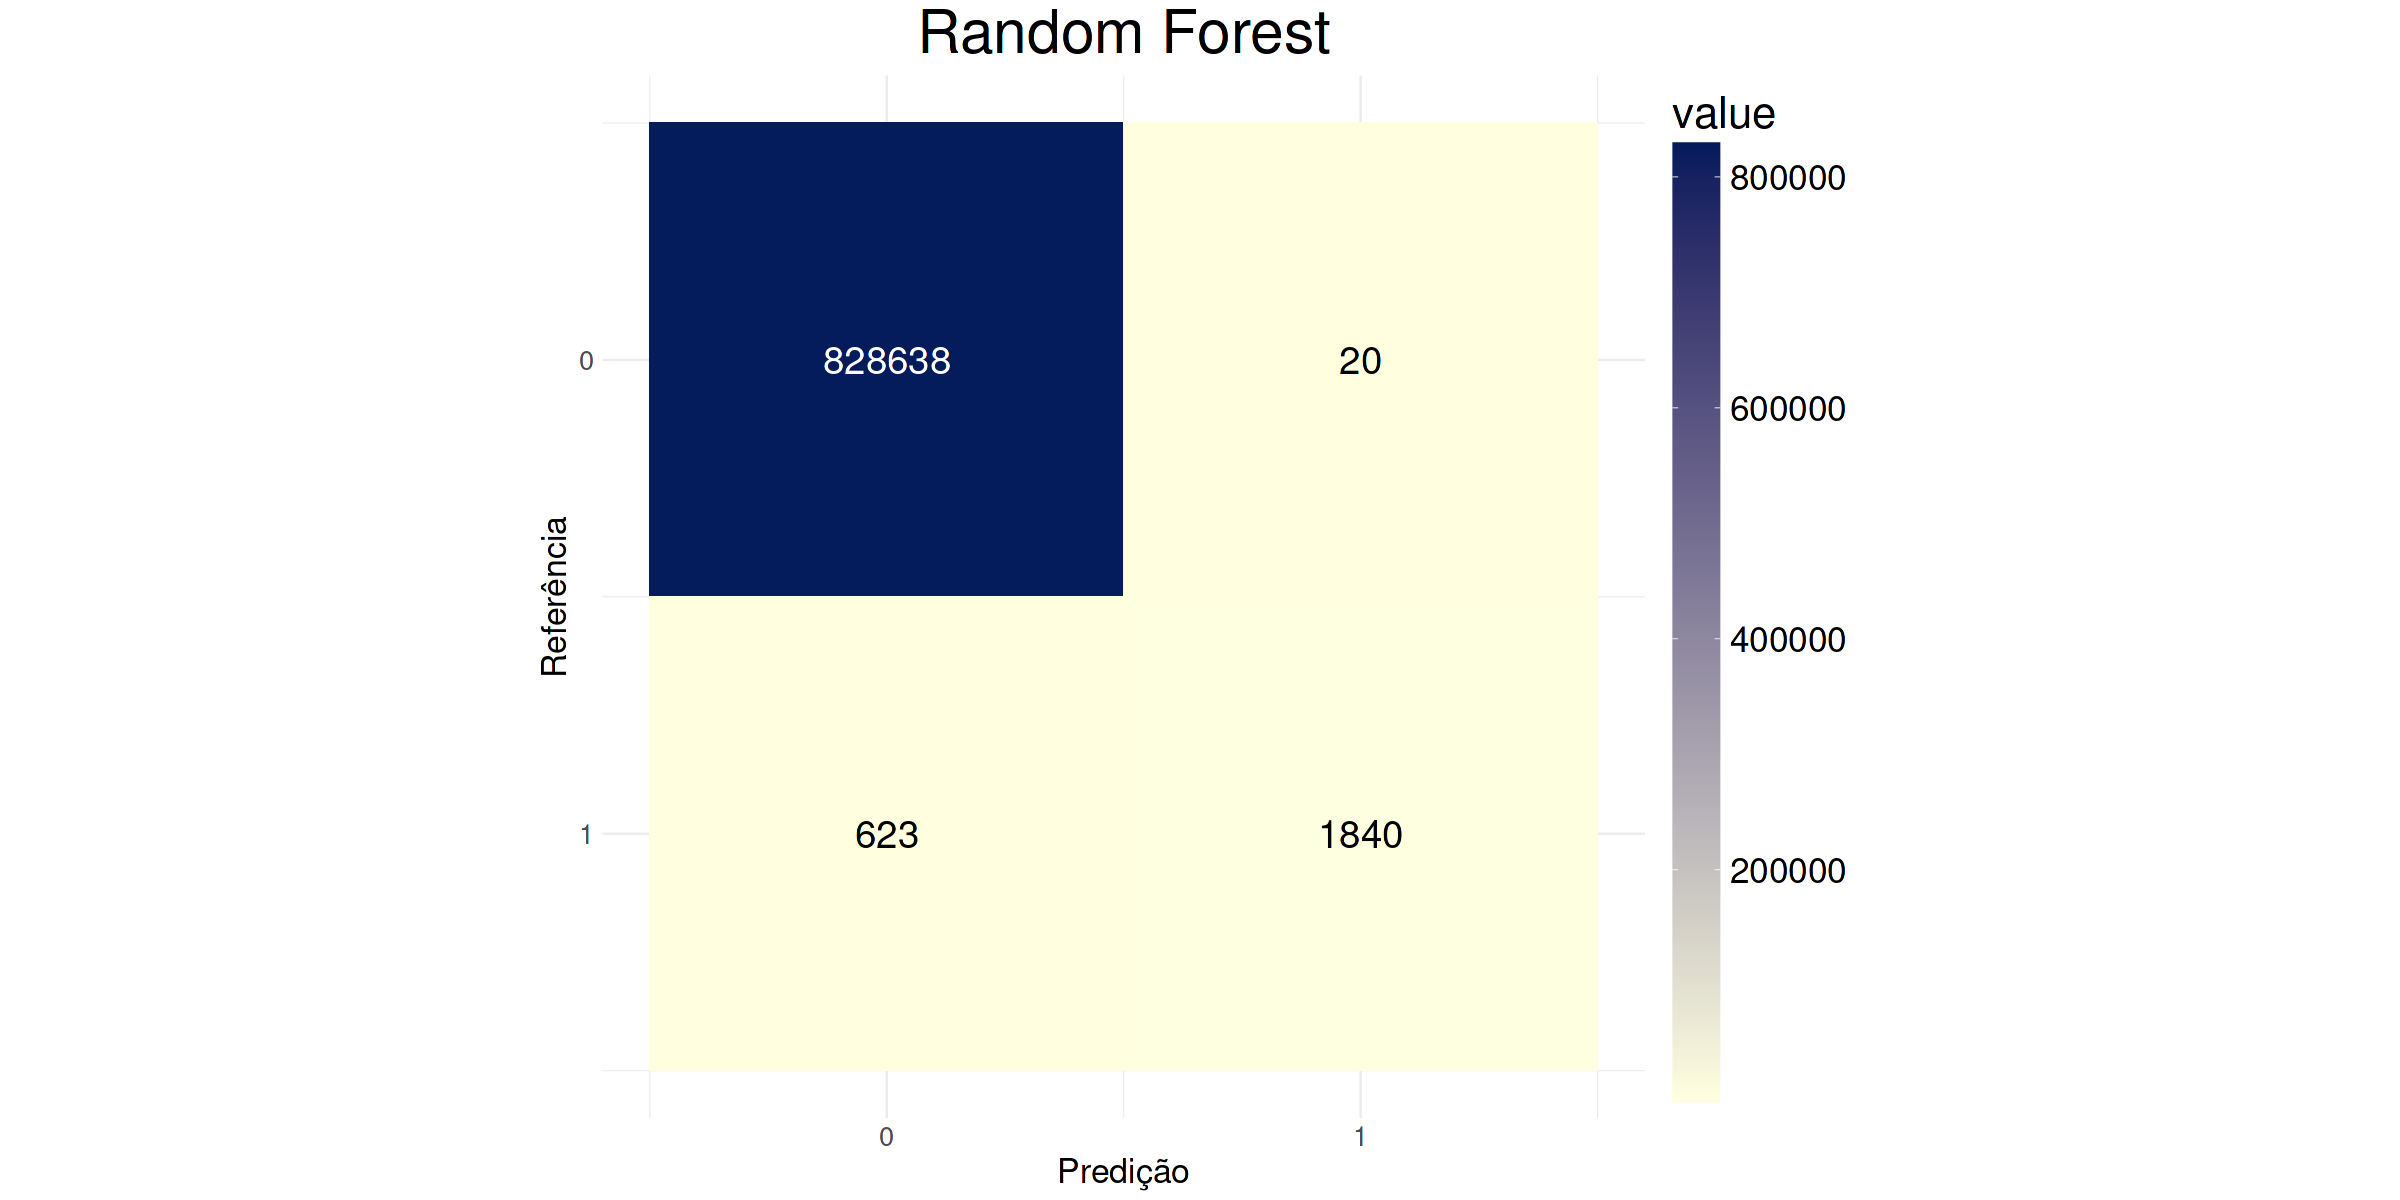

In [58]:
# Extrair a matriz de confusão
conf_matrix <- rf_matriz$table

# Converter a matriz de confusão em formato longo
conf_matrix_long <- melt(conf_matrix)

ggplot(conf_matrix_long, aes(x = Reference, y = Prediction, fill = value)) +
  geom_tile() +
  # Definir cor do texto com base no valor
  geom_text(aes(label = value, color = ifelse(value > 500000, "white", "black")), size = 8) +  # Tamanho do texto
  scale_fill_gradient(low = "lightyellow", high = "#041b5c", guide = guide_colorbar(barwidth = 2, barheight = 40)) +  # Aumenta a barra da escala
  scale_color_manual(values = c("black", "white"), guide = "none") +  # Definir as cores do texto
  scale_y_reverse(breaks = c(0, 1), labels = c("0", "1")) +  # Inverter e centralizar o eixo Y
  scale_x_continuous(breaks = c(0, 1), labels = c("0", "1")) +  # Centralizar o eixo X
  labs(title = "Random Forest", x = "Predição", y = "Referência") +
  coord_fixed() +  # Define proporção 1:1 para garantir quadrados
  theme_minimal() +
  theme(
    text = element_text(size = 26),           # Aumenta o tamanho da fonte geral
    axis.title.x = element_text(size = 20),   # Tamanho do título do eixo X
    axis.title.y = element_text(size = 20),   # Tamanho do título do eixo Y
    axis.text.x = element_text(size = 16),    # Tamanho dos valores no eixo X
    axis.text.y = element_text(size = 16),    # Tamanho dos valores no eixo Y
    plot.title = element_text(size = 36, hjust = 0.5)  # Tamanho do título principal e centraliza
  )

In [59]:
# Modelo de Regressão Logística Binária
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rlb_model_v3, newdata = teste, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rlb_matriz <- confusionMatrix(resultado$observado, resultado$previsto)
rlb_matriz

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 772727  55931
         1    268   2195
                                             
               Accuracy : 0.932              
                 95% CI : (0.932, 0.933)     
    No Information Rate : 0.93               
    P-Value [Acc > NIR] : <0.0000000000000002
                                             
                  Kappa : 0.067              
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.9997             
            Specificity : 0.0378             
         Pos Pred Value : 0.9325             
         Neg Pred Value : 0.8912             
             Prevalence : 0.9301             
         Detection Rate : 0.9297             
   Detection Prevalence : 0.9970             
      Balanced Accuracy : 0.5187             
                                            

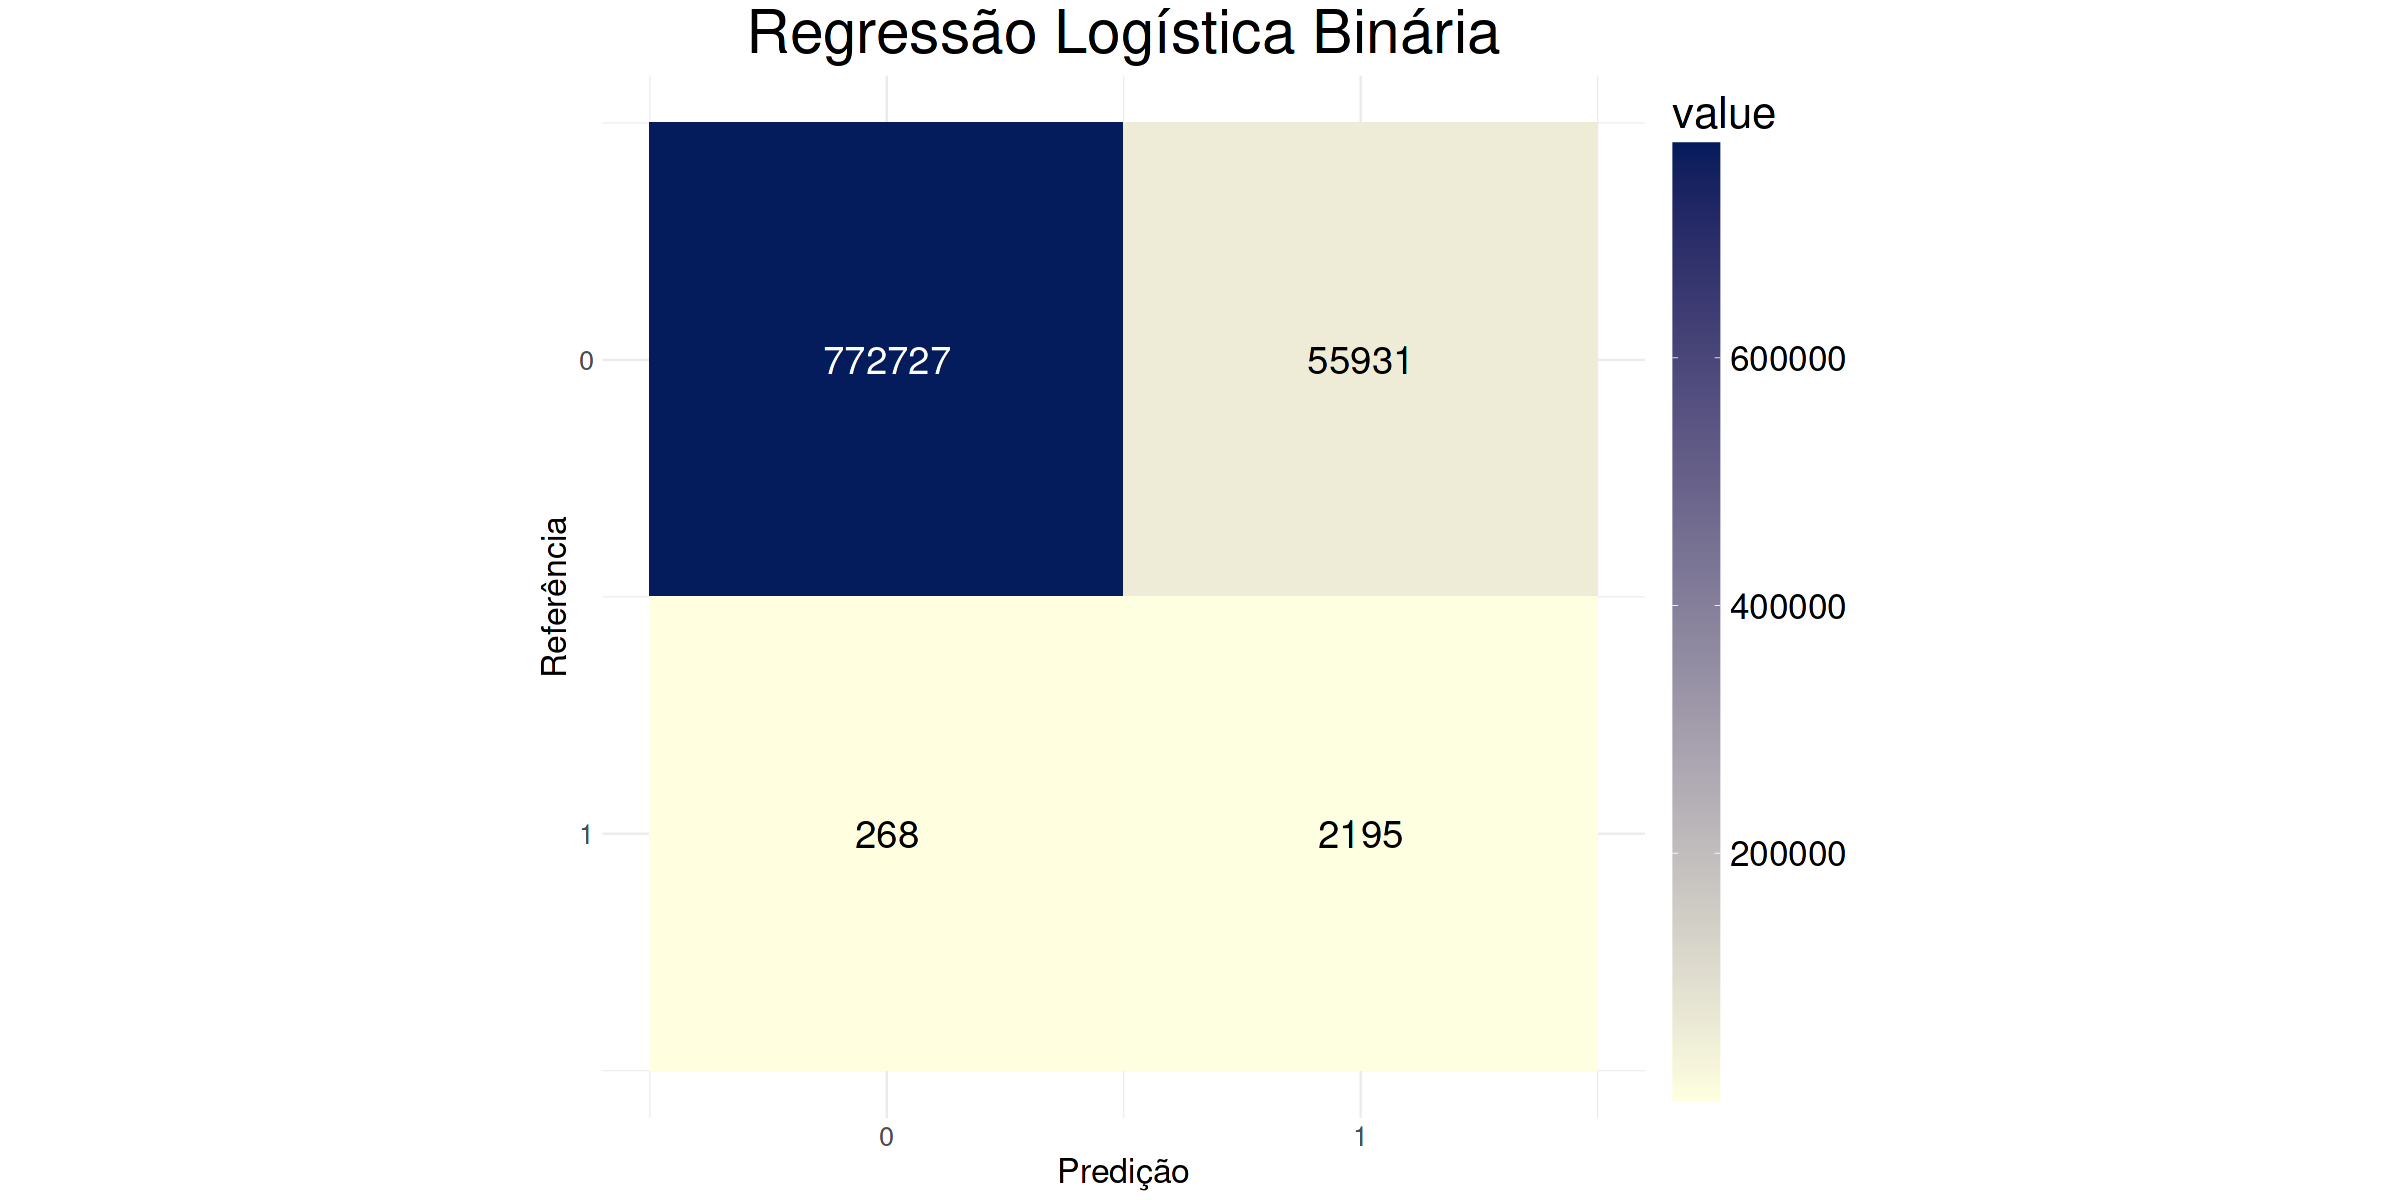

In [60]:
# Extrair a matriz de confusão
conf_matrix <- rlb_matriz$table

# Converter a matriz de confusão em formato longo
conf_matrix_long <- melt(conf_matrix)

ggplot(conf_matrix_long, aes(x = Reference, y = Prediction, fill = value)) +
  geom_tile() +
  # Definir cor do texto com base no valor
  geom_text(aes(label = value, color = ifelse(value > 500000, "white", "black")), size = 8) +  # Tamanho do texto
  scale_fill_gradient(low = "lightyellow", high = "#041b5c", guide = guide_colorbar(barwidth = 2, barheight = 40)) +  # Aumenta a barra da escala
  scale_color_manual(values = c("black", "white"), guide = "none") +  # Definir as cores do texto
  scale_y_reverse(breaks = c(0, 1), labels = c("0", "1")) +  # Inverter e centralizar o eixo Y
  scale_x_continuous(breaks = c(0, 1), labels = c("0", "1")) +  # Centralizar o eixo X
  labs(title = "Regressão Logística Binária", x = "Predição", y = "Referência") +
  coord_fixed() +  # Define proporção 1:1 para garantir quadrados
  theme_minimal() +
  theme(
    text = element_text(size = 26),           # Aumenta o tamanho da fonte geral
    axis.title.x = element_text(size = 20),   # Tamanho do título do eixo X
    axis.title.y = element_text(size = 20),   # Tamanho do título do eixo Y
    axis.text.x = element_text(size = 16),    # Tamanho dos valores no eixo X
    axis.text.y = element_text(size = 16),    # Tamanho dos valores no eixo Y
    plot.title = element_text(size = 36, hjust = 0.5)  # Tamanho do título principal e centraliza
  )

In [61]:
# Modelo de Regressão XGBoost
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(xgb_model_v3, newdata = teste, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
xgb_matriz <- confusionMatrix(resultado$observado, resultado$previsto)
xgb_matriz

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 828428    230
         1      6   2457
                                             
               Accuracy : 1                  
                 95% CI : (1, 1)             
    No Information Rate : 0.997              
    P-Value [Acc > NIR] : <0.0000000000000002
                                             
                  Kappa : 0.954              
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 1.000              
            Specificity : 0.914              
         Pos Pred Value : 1.000              
         Neg Pred Value : 0.998              
             Prevalence : 0.997              
         Detection Rate : 0.997              
   Detection Prevalence : 0.997              
      Balanced Accuracy : 0.957              
                                            

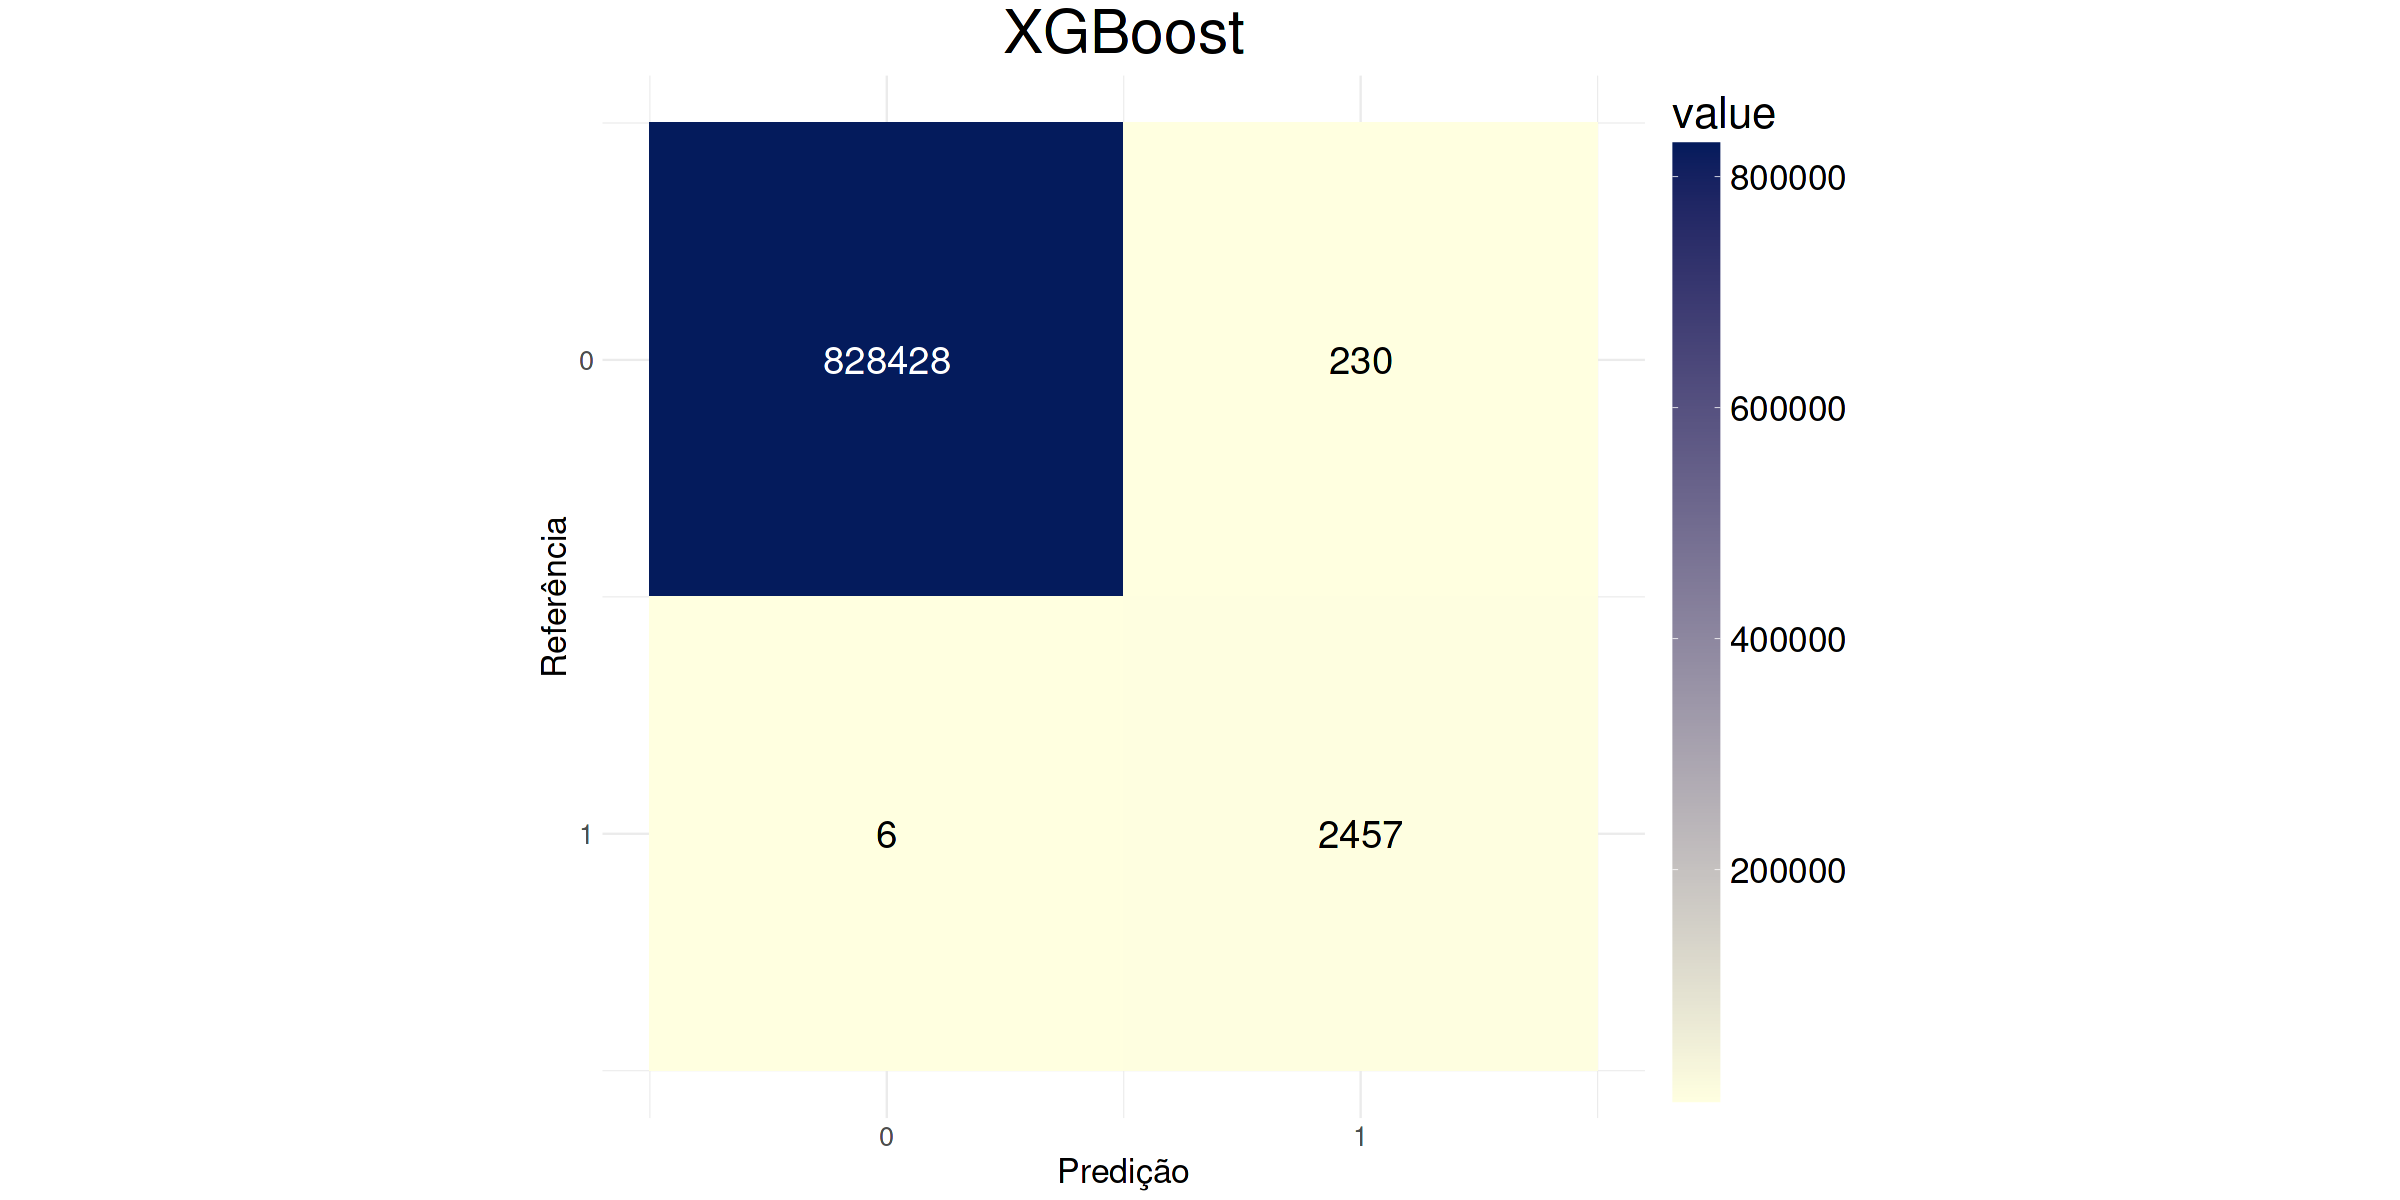

In [63]:
# Extrair a matriz de confusão
conf_matrix <- xgb_matriz$table

# Converter a matriz de confusão em formato longo
conf_matrix_long <- melt(conf_matrix)

ggplot(conf_matrix_long, aes(x = Reference, y = Prediction, fill = value)) +
  geom_tile() +
  # Definir cor do texto com base no valor
  geom_text(aes(label = value, color = ifelse(value > 500000, "white", "black")), size = 8) +  # Tamanho do texto
  scale_fill_gradient(low = "lightyellow", high = "#041b5c", guide = guide_colorbar(barwidth = 2, barheight = 40)) +  # Aumenta a barra da escala
  scale_color_manual(values = c("black", "white"), guide = "none") +  # Definir as cores do texto
  scale_y_reverse(breaks = c(0, 1), labels = c("0", "1")) +  # Inverter e centralizar o eixo Y
  scale_x_continuous(breaks = c(0, 1), labels = c("0", "1")) +  # Centralizar o eixo X
  labs(title = "XGBoost", x = "Predição", y = "Referência") +
  coord_fixed() +  # Define proporção 1:1 para garantir quadrados
  theme_minimal() +
  theme(
    text = element_text(size = 26),           # Aumenta o tamanho da fonte geral
    axis.title.x = element_text(size = 20),   # Tamanho do título do eixo X
    axis.title.y = element_text(size = 20),   # Tamanho do título do eixo Y
    axis.text.x = element_text(size = 16),    # Tamanho dos valores no eixo X
    axis.text.y = element_text(size = 16),    # Tamanho dos valores no eixo Y
    plot.title = element_text(size = 36, hjust = 0.5)  # Tamanho do título principal e centraliza
  )

In [64]:
# Modelo de Redes Neurais Artificiais
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(rna_model_v2, newdata = teste, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
rna_matriz <- confusionMatrix(resultado$observado, resultado$previsto)
rna_matriz

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 810165  18493
         1    572   1891
                                             
               Accuracy : 0.977              
                 95% CI : (0.977, 0.977)     
    No Information Rate : 0.975              
    P-Value [Acc > NIR] : <0.0000000000000002
                                             
                  Kappa : 0.161              
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.9993             
            Specificity : 0.0928             
         Pos Pred Value : 0.9777             
         Neg Pred Value : 0.7678             
             Prevalence : 0.9755             
         Detection Rate : 0.9748             
   Detection Prevalence : 0.9970             
      Balanced Accuracy : 0.5460             
                                            

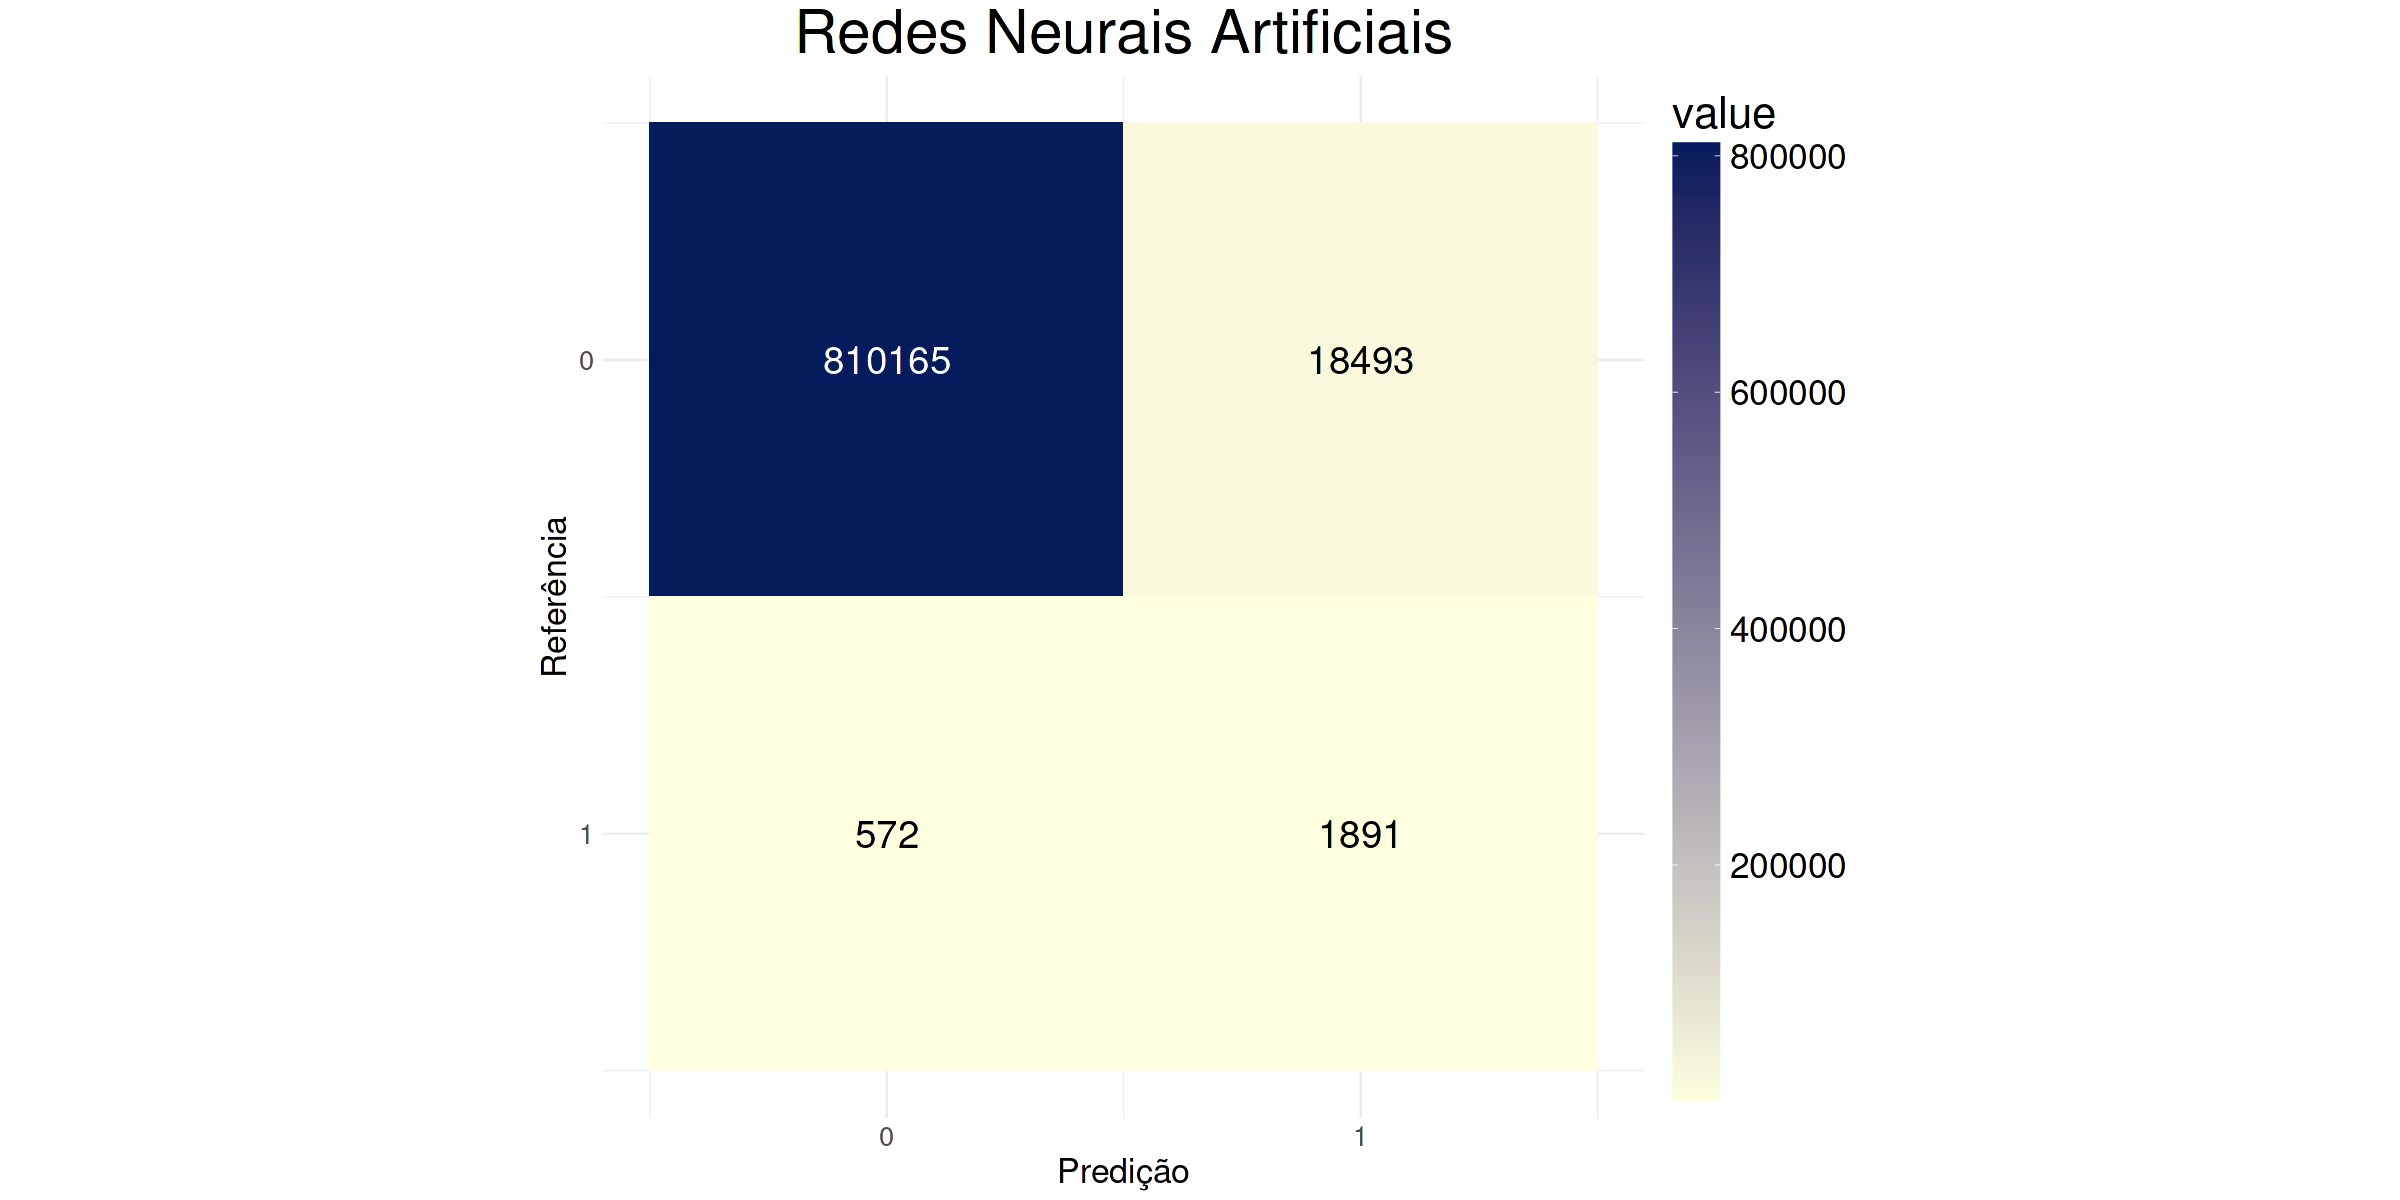

In [65]:
# Extrair a matriz de confusão
conf_matrix <- rna_matriz$table

# Converter a matriz de confusão em formato longo
conf_matrix_long <- melt(conf_matrix)

ggplot(conf_matrix_long, aes(x = Reference, y = Prediction, fill = value)) +
  geom_tile() +
  # Definir cor do texto com base no valor
  geom_text(aes(label = value, color = ifelse(value > 500000, "white", "black")), size = 8) +  # Tamanho do texto
  scale_fill_gradient(low = "lightyellow", high = "#041b5c", guide = guide_colorbar(barwidth = 2, barheight = 40)) +  # Aumenta a barra da escala
  scale_color_manual(values = c("black", "white"), guide = "none") +  # Definir as cores do texto
  scale_y_reverse(breaks = c(0, 1), labels = c("0", "1")) +  # Inverter e centralizar o eixo Y
  scale_x_continuous(breaks = c(0, 1), labels = c("0", "1")) +  # Centralizar o eixo X
  labs(title = "Redes Neurais Artificiais", x = "Predição", y = "Referência") +
  coord_fixed() +  # Define proporção 1:1 para garantir quadrados
  theme_minimal() +
  theme(
    text = element_text(size = 26),           # Aumenta o tamanho da fonte geral
    axis.title.x = element_text(size = 20),   # Tamanho do título do eixo X
    axis.title.y = element_text(size = 20),   # Tamanho do título do eixo Y
    axis.text.x = element_text(size = 16),    # Tamanho dos valores no eixo X
    axis.text.y = element_text(size = 16),    # Tamanho dos valores no eixo Y
    plot.title = element_text(size = 36, hjust = 0.5)  # Tamanho do título principal e centraliza
  )

In [67]:
# Modelo de Support Vector Machine
# Aplicando novos dados com a base de teste
resultado <- data.frame(
    observado = factor(teste$isfraude, levels = c(0,1)),
    previsto = factor(ifelse(predict(svm_model_v4, newdata = teste, type = "prob")[,2] >= 0.5,1,0), levels = c(0,1))
)

# Matriz de Confusão
svm_matriz <- confusionMatrix(resultado$observado, resultado$previsto)
svm_matriz

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 813278  15380
         1    170   2293
                                             
               Accuracy : 0.981              
                 95% CI : (0.981, 0.982)     
    No Information Rate : 0.979              
    P-Value [Acc > NIR] : <0.0000000000000002
                                             
                  Kappa : 0.224              
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 1.000              
            Specificity : 0.130              
         Pos Pred Value : 0.981              
         Neg Pred Value : 0.931              
             Prevalence : 0.979              
         Detection Rate : 0.979              
   Detection Prevalence : 0.997              
      Balanced Accuracy : 0.565              
                                            

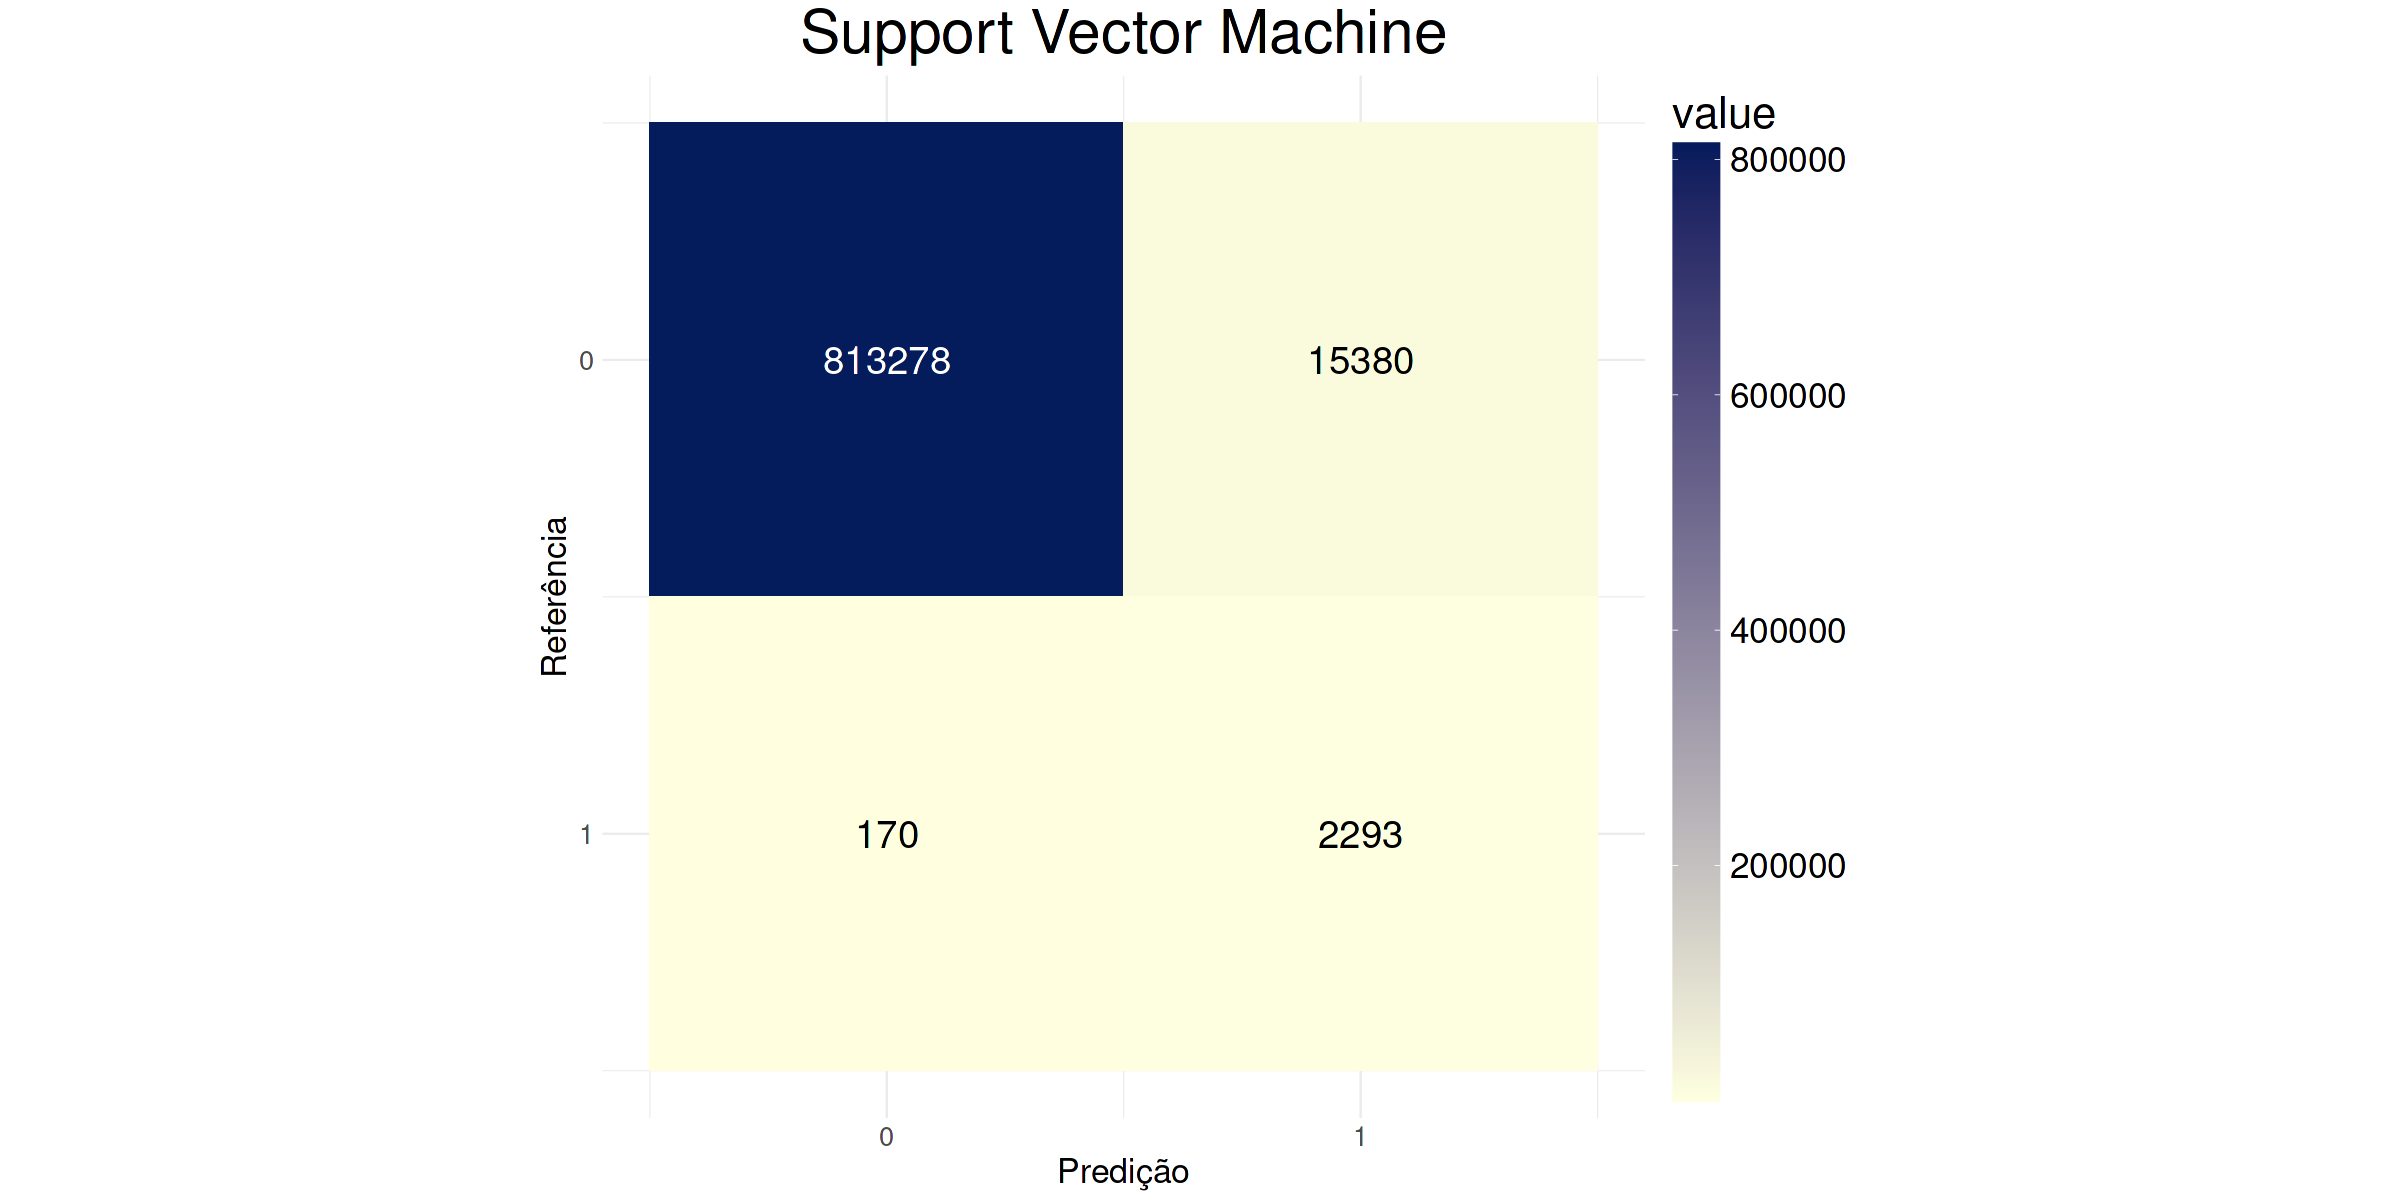

In [68]:
# Extrair a matriz de confusão
conf_matrix <- svm_matriz$table

# Converter a matriz de confusão em formato longo
conf_matrix_long <- melt(conf_matrix)

ggplot(conf_matrix_long, aes(x = Reference, y = Prediction, fill = value)) +
  geom_tile() +
  # Definir cor do texto com base no valor
  geom_text(aes(label = value, color = ifelse(value > 500000, "white", "black")), size = 8) +  # Tamanho do texto
  scale_fill_gradient(low = "lightyellow", high = "#041b5c", guide = guide_colorbar(barwidth = 2, barheight = 40)) +  # Aumenta a barra da escala
  scale_color_manual(values = c("black", "white"), guide = "none") +  # Definir as cores do texto
  scale_y_reverse(breaks = c(0, 1), labels = c("0", "1")) +  # Inverter e centralizar o eixo Y
  scale_x_continuous(breaks = c(0, 1), labels = c("0", "1")) +  # Centralizar o eixo X
  labs(title = "Support Vector Machine", x = "Predição", y = "Referência") +
  coord_fixed() +  # Define proporção 1:1 para garantir quadrados
  theme_minimal() +
  theme(
    text = element_text(size = 26),           # Aumenta o tamanho da fonte geral
    axis.title.x = element_text(size = 20),   # Tamanho do título do eixo X
    axis.title.y = element_text(size = 20),   # Tamanho do título do eixo Y
    axis.text.x = element_text(size = 16),    # Tamanho dos valores no eixo X
    axis.text.y = element_text(size = 16),    # Tamanho dos valores no eixo Y
    plot.title = element_text(size = 36, hjust = 0.5)  # Tamanho do título principal e centraliza
  )

In [43]:
# Gerando as classes de dados para os modelos
classe1_model1 <- predict(rf_model_v3, newdata = teste, type = 'prob')
classe1_model2 <- predict(rlb_model_v3, newdata = teste, type = 'prob')
classe1_model3 <- predict(xgb_model_v3, newdata = teste, type = 'prob')
classe1_model4 <- predict(rna_model_v2, newdata = teste, type = 'prob')
classe1_model5 <- predict(svm_model_v4, newdata = teste, type = 'prob')

# Classes reais
classe2 <- teste$isfraude

# Gerando a curva ROC e AUC para cada modelo
pred_model1 <- ROCR::prediction(classe1_model1[,2], classe2)
perf_model1 <- ROCR::performance(pred_model1, 'tpr', 'fpr')
auc_model1 <- ROCR::performance(pred_model1, measure = "auc")@y.values[[1]]

pred_model2 <- ROCR::prediction(classe1_model2[,2], classe2)
perf_model2 <- ROCR::performance(pred_model2, 'tpr', 'fpr')
auc_model2 <- ROCR::performance(pred_model2, measure = "auc")@y.values[[1]]

pred_model3 <- ROCR::prediction(classe1_model3[,2], classe2)
perf_model3 <- ROCR::performance(pred_model3, 'tpr', 'fpr')
auc_model3 <- ROCR::performance(pred_model3, measure = "auc")@y.values[[1]]

pred_model4 <- ROCR::prediction(classe1_model4[,2], classe2)
perf_model4 <- ROCR::performance(pred_model4, 'tpr', 'fpr')
auc_model4 <- ROCR::performance(pred_model4, measure = "auc")@y.values[[1]]

pred_model5 <- ROCR::prediction(classe1_model5[,2], classe2)
perf_model5 <- ROCR::performance(pred_model5, 'tpr', 'fpr')
auc_model5 <- ROCR::performance(pred_model5, measure = "auc")@y.values[[1]]

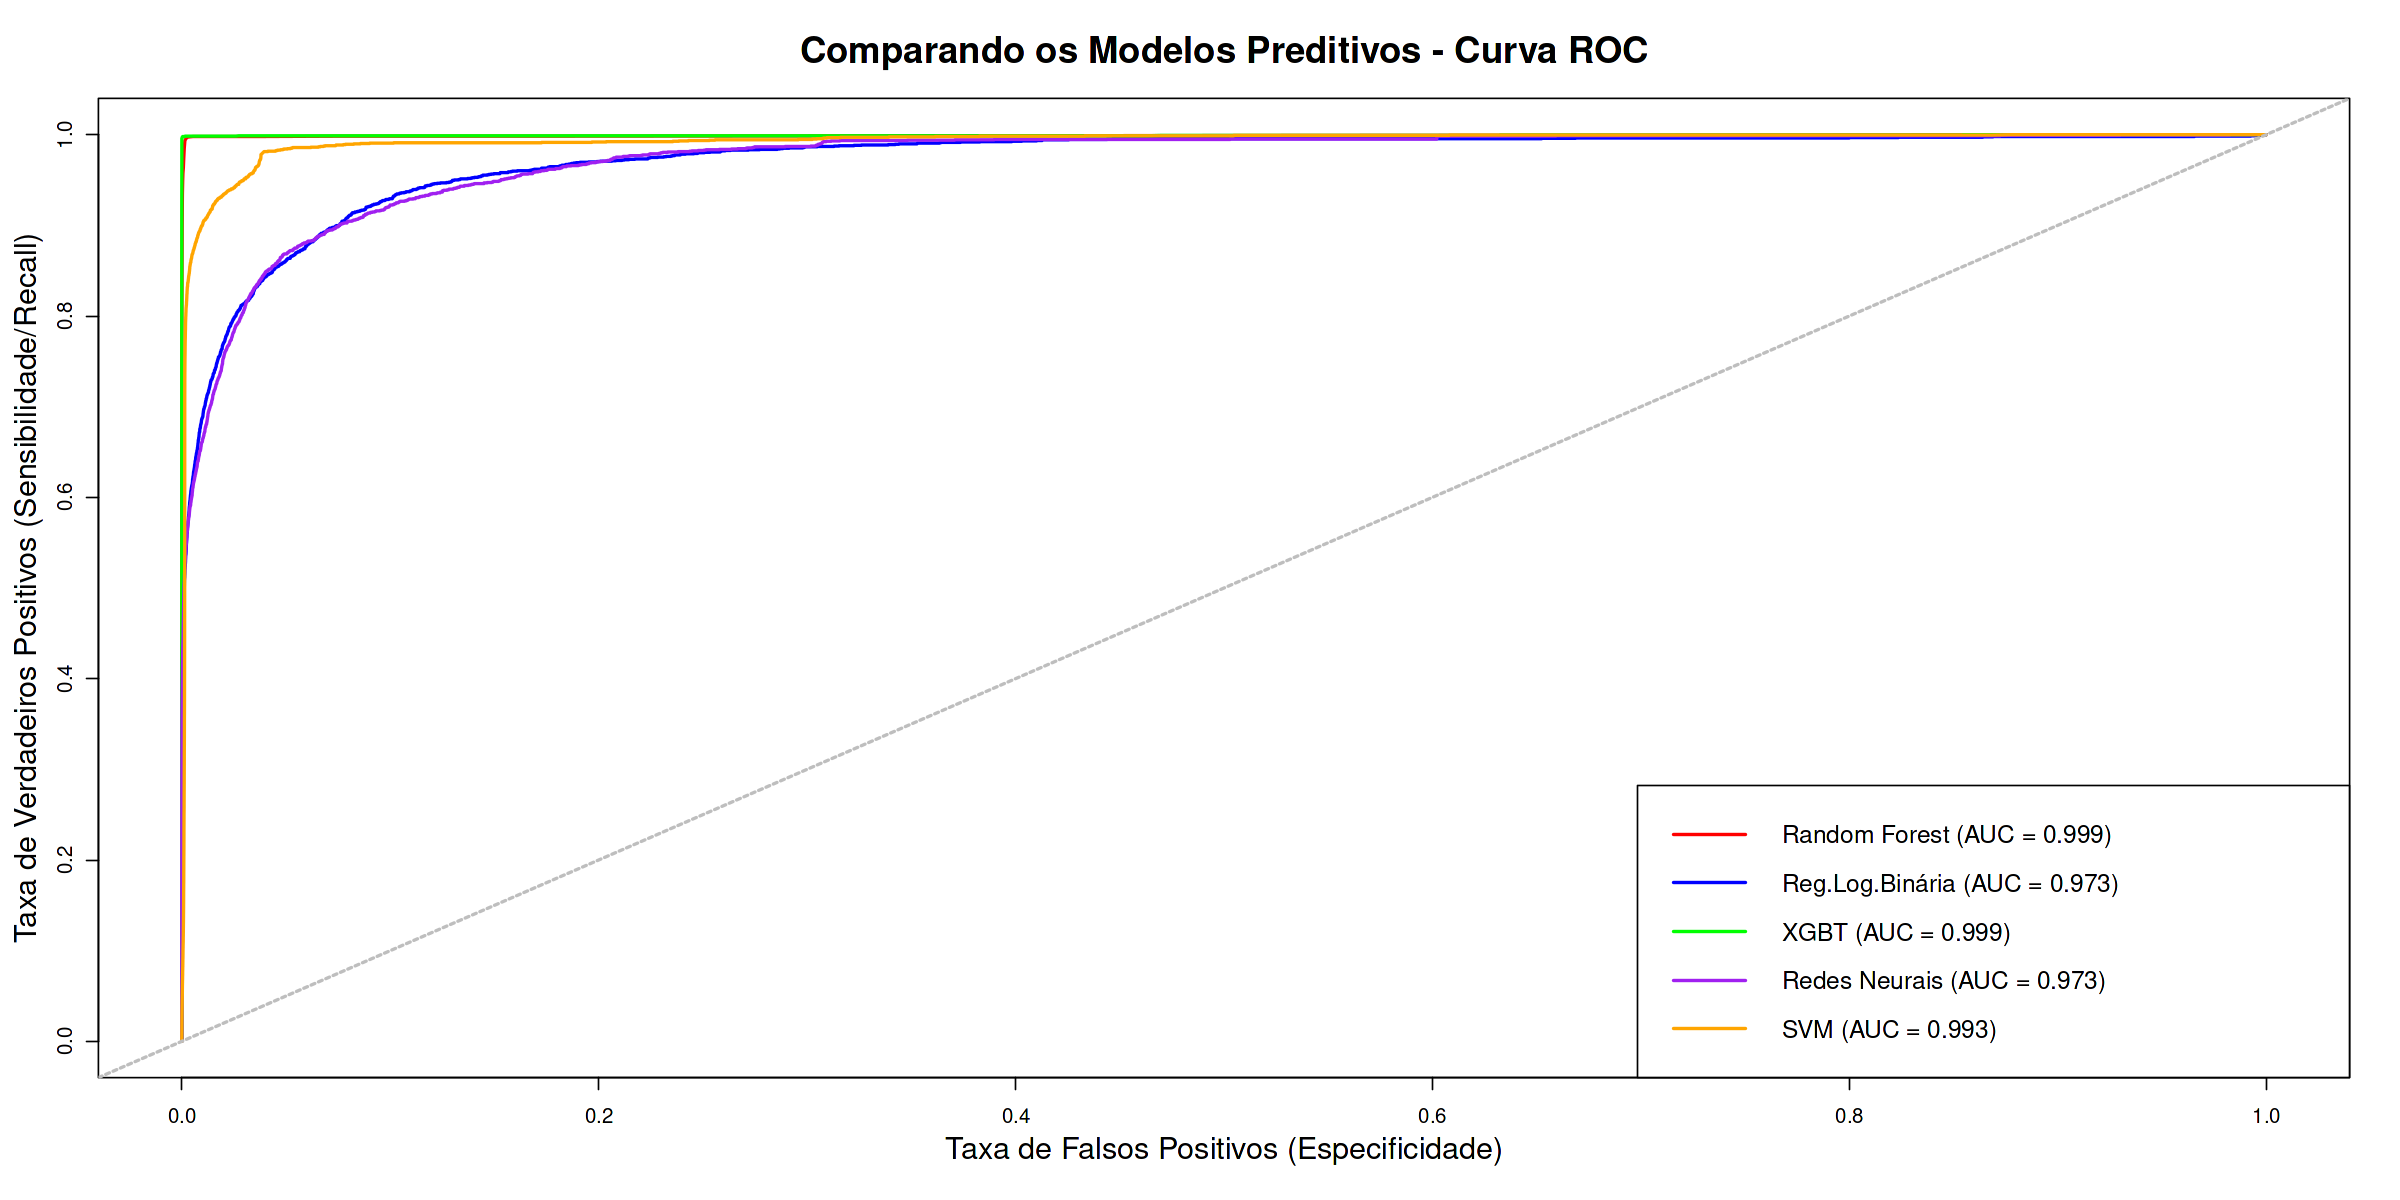

In [10]:
# Ajustando as margens do gráfico e o recuo dos rótulos dos eixos
par(mgp = c(2.5, 1, 0)) # Aumentando o recuo dos rótulos dos eixos

# Gerando os gráficos das curvas ROC e ajustando o tamanho da fonte
plot(perf_model1, col = "red", lwd = 2, main = "Comparando os Modelos Preditivos - Curva ROC",
     cex.main = 1.8, # Tamanho da fonte do título
     xlab = "Taxa de Falsos Positivos (Especificidade)", 
     ylab = "Taxa de Verdadeiros Positivos (Sensibilidade/Recall)", 
     cex.lab = 1.5, # Tamanho da fonte dos rótulos dos eixos
     cex.axis = 1.5) # Tamanho da fonte dos textos dos eixos

# Adicionando as curvas ROC dos outros modelos
plot(perf_model2, col = "blue", lwd = 2, add = TRUE)
plot(perf_model3, col = "green", lwd = 2, add = TRUE)
plot(perf_model4, col = "purple", lwd = 2, add = TRUE)
plot(perf_model5, col = "orange", lwd = 2, add = TRUE)

# Adicionando a linha diagonal de referência
abline(a = 0, b = 1, col = "gray", lty = 2, lwd = 2) # Linha diagonal cinza tracejada

# Adicionando uma legenda com os valores de AUC
legend("bottomright", 
       legend = c(
         paste0("Random Forest (AUC = ", round(auc_model1, 3), ")"),
         paste0("Reg.Log.Binária (AUC = ", round(auc_model2, 3), ")"),
         paste0("XGBT (AUC = ", round(auc_model3, 3), ")"),
         paste0("Redes Neurais (AUC = ", round(auc_model4, 3), ")"),
         paste0("SVM (AUC = ", round(auc_model5, 3), ")")
       ),
       col = c("red", "blue", "green", "purple", "orange"), lwd = 2,
       cex = 1.2) # Tamanho da fonte da legenda

Portanto, será escolhido o modelo de Random Forest, por apresentar métricas dentro do esperado no conjunto de teste.
      